In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/anaconda3/envs/teachopencadd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
levels_up = 3
HDAC1= HERE.parents[levels_up-1]/'input'

In [3]:
df = pd.read_pickle(HDAC1/"HDAC1_4492compounds_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl
0,CHEMBL4286867,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...","[6411541, 10511, 137380, 1877151, 4783723, 486...",518.264154,12.0,38.0,8.0,4.0,4.5083,3.0,1.0,1.0,7.25
1,CHEMBL3689853,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4035923, 6538203, 2344420, 16829770, 4517655,...",400.247441,7.0,29.0,6.0,2.0,3.0088,2.0,1.0,1.0,6.43
2,CHEMBL3827056,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[3826379, 2478511, 2013766, 10841999, 1139606,...",611.182805,6.0,43.0,11.0,2.0,3.4499,4.0,1.0,1.0,7.52
3,CHEMBL3689883,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1429681, 7687405, 6095547, 12157985, 9830328,...",386.268176,9.0,28.0,5.0,2.0,4.0635,2.0,0.0,0.0,7.70
4,CHEMBL2023528,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[371106, 825901, 1055378, 943140, 1666919, 191...",813.322122,14.0,59.0,16.0,7.0,3.1843,4.0,1.0,3.0,7.27


In [4]:
df_labeled = pd.read_csv(HDAC1/"HDAC1_4492compounds_withTypes-Ki_newThreshold.csv", index_col=0)
df_labeled

,molecule_chembl_id,smiles,pActivity,label
0,CHEMBL327146,O=C(CCCCCC(C(=O)Nc1ccc2ncccc2c1)C(=O)Nc1ccc2nc...,9.00,Single points
1,CHEMBL116620,O=C(/C=C/c1cccc(C(C(=O)Nc2ccccc2)C(=O)Nc2ccccc...,9.00,Single points
2,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,5.20,Single points
3,CHEMBL316457,CC(C)c1cc(C(C)C)c(S(=O)(=O)Nc2ccc(/C=C/C(=O)NO...,6.22,Single points
4,CHEMBL269692,O=C(NCc1ccc(C(=O)NO)cc1)OCc1cccnc1,5.52,Single points
...,...,...,...,...
4487,CHEMBL4649511,O=C(CCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,8.48,Dual-binder
4488,CHEMBL4637976,O=C(CCCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,6.89,Single points
4489,CHEMBL4638227,CC(=O)Nc1ccc2c(c1)CN(C(=O)[C@H](N)Cc1ccc(Cl)cc...,5.06,Single points
4490,CHEMBL4444219,CCCNNC(=O)/C=C/c1ccc(CNCCc2c(C)[nH]c3ccccc23)cc1,8.31,Single points


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')
df.tail()

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label
4487,CHEMBL4464975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[569161, 3913535, 6718756, 2817337, 6615052, 6...",449.114234,6.0,32.0,6.0,2.0,3.22660,4.0,0.0,0.0,4.72,hDAC6-selective
4488,CHEMBL95747,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1260438, 16948577, 1495766, 2469425, 5711363,...",285.172879,8.0,21.0,2.0,2.0,4.22830,2.0,0.0,0.0,7.60,Single points
4489,CHEMBL4072618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13333824, 12708875, 4142580, 33294862, 115873...",425.177313,9.0,30.0,5.0,2.0,3.66800,2.0,0.0,1.0,5.19,Non-binder
4490,CHEMBL2408692,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4681989, 4118356, 4155872, 616889, 1158735, 9...",359.126991,2.0,27.0,4.0,2.0,1.91350,2.0,0.0,1.0,6.36,Non-binder
4491,CHEMBL4226829,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[1888269, 941437, 137380, 1352495, 28861, 3075...",692.273368,12.0,46.0,10.0,4.0,5.49792,2.0,2.0,2.0,5.55,Single points


In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,molecular_weight,n_rot,n_heavy,n_hba,n_hbd,logp,num_ar,num_sa,num_alip,pchembl,label,Class
0,CHEMBL4286867,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...","[6411541, 10511, 137380, 1877151, 4783723, 486...",518.264154,12.0,38.0,8.0,4.0,4.5083,3.0,1.0,1.0,7.25,Semi-selective,5.0
1,CHEMBL3689853,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4035923, 6538203, 2344420, 16829770, 4517655,...",400.247441,7.0,29.0,6.0,2.0,3.0088,2.0,1.0,1.0,6.43,Single points,0.0
2,CHEMBL3827056,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...","[3826379, 2478511, 2013766, 10841999, 1139606,...",611.182805,6.0,43.0,11.0,2.0,3.4499,4.0,1.0,1.0,7.52,Single points,0.0
3,CHEMBL3689883,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1429681, 7687405, 6095547, 12157985, 9830328,...",386.268176,9.0,28.0,5.0,2.0,4.0635,2.0,0.0,0.0,7.70,Single points,0.0


In [7]:
# Add column for activity
df["activity"] = np.zeros(len(df))

# Mark every molecule as active if pchembl value is >=6.6 0 otherwise
df.loc[df[df.pchembl >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["pchembl"].values
Y_cat =  df["activity"].values
Y_class = df['Class'].values
indices =  np.array(df.index)


In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['pchembl'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['pchembl'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6) , 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.676650     0.038483
1                    TP       202.400000    12.624491
2                    TN       171.400000    10.762073
3                    FP        41.600000     9.371351
4                    FN        33.800000     6.957011
5              Accuracy         0.832151     0.025770
6             Precision         0.830039     0.034339
7           Sensitivity         0.856388     0.031545
8           Specificity         0.804810     0.042830
9              F1 score         0.842562     0.025859
10  F1 score (weighted)         0.831833     0.025882
11     F1 score (macro)         0.831053     0.025784
12    Balanced Accuracy         0.830598     0.025722
13                  MCC         0.663651     0.051394
14                  NPV         0.836080     0.028270
15              ROC_AUC         0.830598     0.025722
CPU times: user 3min 40s, sys: 29.9 ms, total: 3min 40s
Wall time: 15.8 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 15:33:49,228] A new study created in memory with name: RFRegressor
[I 2023-02-16 15:35:04,346] Trial 0 finished with value: 0.6571303498036795 and parameters: {'n_estimators': 671}. Best is trial 0 with value: 0.6571303498036795.
[I 2023-02-16 15:36:34,412] Trial 1 finished with value: 0.6570109513642123 and parameters: {'n_estimators': 802}. Best is trial 0 with value: 0.6571303498036795.
[I 2023-02-16 15:37:44,271] Trial 2 finished with value: 0.6568237101063039 and parameters: {'n_estimators': 611}. Best is trial 0 with value: 0.6571303498036795.
[I 2023-02-16 15:38:56,053] Trial 3 finished with value: 0.6569091030368981 and parameters: {'n_estimators': 632}. Best is trial 0 with value: 0.6571303498036795.
[I 2023-02-16 15:39:17,979] Trial 4 finished with value: 0.657411213901814 and parameters: {'n_estimators': 167}. Best is trial 4 with value: 0.657411213901814.
[I 2023-02-16 15:39:47,461] Trial 5 finished with value: 0.6575713839520181 and parameters: {'n_estimators

[I 2023-02-16 16:16:46,753] Trial 46 finished with value: 0.657435414994503 and parameters: {'n_estimators': 295}. Best is trial 22 with value: 0.6580002553574176.
[I 2023-02-16 16:19:03,605] Trial 47 finished with value: 0.6568498187546927 and parameters: {'n_estimators': 997}. Best is trial 22 with value: 0.6580002553574176.
[I 2023-02-16 16:19:59,105] Trial 48 finished with value: 0.6568520302345879 and parameters: {'n_estimators': 400}. Best is trial 22 with value: 0.6580002553574176.
[I 2023-02-16 16:20:19,302] Trial 49 finished with value: 0.6568237827620792 and parameters: {'n_estimators': 140}. Best is trial 22 with value: 0.6580002553574176.


	Number of trials: 50.0
	Best value (r2_score): 0.6580
	Best params:
		n_estimators: 192


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_0_cat = np.where((y_pred_rf_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.653416
1                    TP  396.000000
2                    TN  356.000000
3                    FP   88.000000
4                    FN   59.000000
5              Accuracy    0.836485
6             Precision    0.818182
7           Sensitivity    0.870330
8           Specificity    0.801800
9              F1 score    0.843450
10  F1 score (weighted)    0.836250
11     F1 score (macro)    0.836161
12    Balanced Accuracy    0.836066
13                  MCC    0.674070
14                  NPV    0.857800
15              ROC_AUC    0.836066


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 16:20:59,361] Trial 50 finished with value: 0.664653163396508 and parameters: {'n_estimators': 266}. Best is trial 50 with value: 0.664653163396508.
[I 2023-02-16 16:21:37,309] Trial 51 finished with value: 0.6645507335747272 and parameters: {'n_estimators': 274}. Best is trial 50 with value: 0.664653163396508.
[I 2023-02-16 16:22:13,977] Trial 52 finished with value: 0.6646261242437764 and parameters: {'n_estimators': 265}. Best is trial 50 with value: 0.664653163396508.
[I 2023-02-16 16:23:01,309] Trial 53 finished with value: 0.6655465176109802 and parameters: {'n_estimators': 345}. Best is trial 53 with value: 0.6655465176109802.
[I 2023-02-16 16:23:50,271] Trial 54 finished with value: 0.6657349594183993 and parameters: {'n_estimators': 355}. Best is trial 54 with value: 0.6657349594183993.
[I 2023-02-16 16:24:38,555] Trial 55 finished with value: 0.6656540181949127 and parameters: {'n_estimators': 351}. Best is trial 54 with value: 0.6657349594183993.
[I 2023-02-16 

[I 2023-02-16 17:23:58,351] Trial 97 finished with value: 0.6668428321083215 and parameters: {'n_estimators': 563}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:25:23,125] Trial 98 finished with value: 0.6668973966533984 and parameters: {'n_estimators': 622}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:27:04,552] Trial 99 finished with value: 0.6665041277227564 and parameters: {'n_estimators': 747}. Best is trial 95 with value: 0.6669588257083872.


	Number of trials: 100.0
	Best value (r2_score): 0.6670
	Best params:
		n_estimators: 628


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_1_cat = np.where((y_pred_rf_1 >= 6.6), 1, 0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.653416    0.660333
1                    TP  396.000000  409.000000
2                    TN  356.000000  333.000000
3                    FP   88.000000   83.000000
4                    FN   59.000000   74.000000
5              Accuracy    0.836485    0.825362
6             Precision    0.818182    0.831301
7           Sensitivity    0.870330    0.846791
8           Specificity    0.801800    0.800500
9              F1 score    0.843450    0.838974
10  F1 score (weighted)    0.836250    0.825213
11     F1 score (macro)    0.836161    0.824104
12    Balanced Accuracy    0.836066    0.823636
13                  MCC    0.674070    0.648376
14                  NPV    0.857800    0.818200
15              ROC_AUC    0.836066    0.823636


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 17:28:39,479] Trial 100 finished with value: 0.6618669751017239 and parameters: {'n_estimators': 631}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:30:01,581] Trial 101 finished with value: 0.6618543194964597 and parameters: {'n_estimators': 605}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:31:33,382] Trial 102 finished with value: 0.6619911026466012 and parameters: {'n_estimators': 682}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:32:58,963] Trial 103 finished with value: 0.6618768288750569 and parameters: {'n_estimators': 628}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:34:21,284] Trial 104 finished with value: 0.6618493434263647 and parameters: {'n_estimators': 607}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 17:35:38,599] Trial 105 finished with value: 0.6619778675542485 and parameters: {'n_estimators': 570}. Best is trial 95 with value: 0.6669588257083872.
[I 2

[I 2023-02-16 18:41:28,978] Trial 146 finished with value: 0.6619869366373615 and parameters: {'n_estimators': 590}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 18:42:57,776] Trial 147 finished with value: 0.6618816957862379 and parameters: {'n_estimators': 622}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 18:44:41,132] Trial 148 finished with value: 0.6619218438290575 and parameters: {'n_estimators': 492}. Best is trial 95 with value: 0.6669588257083872.
[I 2023-02-16 18:47:31,514] Trial 149 finished with value: 0.6618758657899126 and parameters: {'n_estimators': 650}. Best is trial 95 with value: 0.6669588257083872.


	Number of trials: 150.0
	Best value (r2_score): 0.6670
	Best params:
		n_estimators: 628


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_2_cat = np.where((y_pred_rf_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.653416    0.660333    0.677432
1                    TP  396.000000  409.000000  417.000000
2                    TN  356.000000  333.000000  330.000000
3                    FP   88.000000   83.000000   93.000000
4                    FN   59.000000   74.000000   59.000000
5              Accuracy    0.836485    0.825362    0.830923
6             Precision    0.818182    0.831301    0.817647
7           Sensitivity    0.870330    0.846791    0.876050
8           Specificity    0.801800    0.800500    0.780100
9              F1 score    0.843450    0.838974    0.845842
10  F1 score (weighted)    0.836250    0.825213    0.830299
11     F1 score (macro)    0.836161    0.824104    0.829325
12    Balanced Accuracy    0.836066    0.823636    0.828096
13                  MCC    0.674070    0.648376    0.661066
14                  NPV    0.857800    0.818200    0.848300
15              ROC_AUC    0.836066    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 18:49:32,794] Trial 150 finished with value: 0.669695415816513 and parameters: {'n_estimators': 680}. Best is trial 150 with value: 0.669695415816513.
[I 2023-02-16 18:51:08,138] Trial 151 finished with value: 0.6697349065227234 and parameters: {'n_estimators': 678}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 18:52:44,451] Trial 152 finished with value: 0.6696864252214587 and parameters: {'n_estimators': 689}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 18:54:28,072] Trial 153 finished with value: 0.6697266633888361 and parameters: {'n_estimators': 733}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 18:56:11,503] Trial 154 finished with value: 0.6696696629561133 and parameters: {'n_estimators': 739}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 18:57:54,298] Trial 155 finished with value: 0.6696818122383852 and parameters: {'n_estimators': 736}. Best is trial 151 with value: 0.6697349065227234.


[I 2023-02-16 20:20:18,687] Trial 196 finished with value: 0.6694681837118097 and parameters: {'n_estimators': 764}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:22:03,222] Trial 197 finished with value: 0.6695765493400405 and parameters: {'n_estimators': 748}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:23:46,527] Trial 198 finished with value: 0.6697006406461188 and parameters: {'n_estimators': 738}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:25:30,234] Trial 199 finished with value: 0.6697006406461189 and parameters: {'n_estimators': 738}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 200.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_3_cat = np.where((y_pred_rf_3 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.653416    0.660333    0.677432    0.668564
1                    TP  396.000000  409.000000  417.000000  405.000000
2                    TN  356.000000  333.000000  330.000000  338.000000
3                    FP   88.000000   83.000000   93.000000   88.000000
4                    FN   59.000000   74.000000   59.000000   68.000000
5              Accuracy    0.836485    0.825362    0.830923    0.826474
6             Precision    0.818182    0.831301    0.817647    0.821501
7           Sensitivity    0.870330    0.846791    0.876050    0.856237
8           Specificity    0.801800    0.800500    0.780100    0.793400
9              F1 score    0.843450    0.838974    0.845842    0.838509
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505
12    Balanced Accuracy    0.836066    0.823636    0.828096    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 20:27:28,117] Trial 200 finished with value: 0.6665694200565467 and parameters: {'n_estimators': 737}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:29:18,994] Trial 201 finished with value: 0.6664420135327204 and parameters: {'n_estimators': 760}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:31:04,769] Trial 202 finished with value: 0.6665779750612192 and parameters: {'n_estimators': 733}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:32:55,590] Trial 203 finished with value: 0.6664109711579955 and parameters: {'n_estimators': 766}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:34:53,059] Trial 204 finished with value: 0.6664207635146703 and parameters: {'n_estimators': 812}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 20:36:41,813] Trial 205 finished with value: 0.6665666297351436 and parameters: {'n_estimators': 746}. Best is trial 151 with value: 0.6697349065227234

[I 2023-02-16 21:52:30,968] Trial 246 finished with value: 0.6667033591727333 and parameters: {'n_estimators': 717}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 21:54:19,075] Trial 247 finished with value: 0.6665501035462447 and parameters: {'n_estimators': 744}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 21:56:10,418] Trial 248 finished with value: 0.6664329406214285 and parameters: {'n_estimators': 771}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 21:58:07,352] Trial 249 finished with value: 0.6664154056671958 and parameters: {'n_estimators': 807}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 250.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_4_cat = np.where((y_pred_rf_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 22:00:07,277] Trial 250 finished with value: 0.6602604320274646 and parameters: {'n_estimators': 761}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 22:01:59,614] Trial 251 finished with value: 0.6602221878255696 and parameters: {'n_estimators': 788}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 22:03:45,394] Trial 252 finished with value: 0.6602645228888255 and parameters: {'n_estimators': 733}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 22:05:33,785] Trial 253 finished with value: 0.6602713411369847 and parameters: {'n_estimators': 747}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 22:07:15,013] Trial 254 finished with value: 0.6602184817510445 and parameters: {'n_estimators': 710}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 22:09:04,713] Trial 255 finished with value: 0.6602580257327804 and parameters: {'n_estimators': 771}. Best is trial 151 with value: 0.6697349065227234

[I 2023-02-16 23:23:40,252] Trial 296 finished with value: 0.6601933457542131 and parameters: {'n_estimators': 792}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:25:17,683] Trial 297 finished with value: 0.6600878326558065 and parameters: {'n_estimators': 681}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:27:07,660] Trial 298 finished with value: 0.6603162170061933 and parameters: {'n_estimators': 765}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:28:53,424] Trial 299 finished with value: 0.6602901217079259 and parameters: {'n_estimators': 740}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 300.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_5_cat = np.where((y_pred_rf_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-16 23:30:56,958] Trial 300 finished with value: 0.6609236508897863 and parameters: {'n_estimators': 777}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:32:54,478] Trial 301 finished with value: 0.6609711910670725 and parameters: {'n_estimators': 811}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:34:39,443] Trial 302 finished with value: 0.6607667938100265 and parameters: {'n_estimators': 725}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:36:26,907] Trial 303 finished with value: 0.6607401793206764 and parameters: {'n_estimators': 753}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:38:05,420] Trial 304 finished with value: 0.6607346584338323 and parameters: {'n_estimators': 707}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-16 23:39:56,005] Trial 305 finished with value: 0.6609463975600953 and parameters: {'n_estimators': 791}. Best is trial 151 with value: 0.6697349065227234

[I 2023-02-17 00:55:45,168] Trial 346 finished with value: 0.6607167320037552 and parameters: {'n_estimators': 750}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 00:57:24,929] Trial 347 finished with value: 0.6607768779989162 and parameters: {'n_estimators': 691}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 00:59:17,251] Trial 348 finished with value: 0.6609557100142008 and parameters: {'n_estimators': 780}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:01:07,419] Trial 349 finished with value: 0.6609283034436211 and parameters: {'n_estimators': 764}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 350.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_6_cat = np.where((y_pred_rf_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 01:03:19,836] Trial 350 finished with value: 0.6689743190130997 and parameters: {'n_estimators': 845}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:05:13,781] Trial 351 finished with value: 0.6690065856378283 and parameters: {'n_estimators': 800}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:06:56,888] Trial 352 finished with value: 0.6691071794012439 and parameters: {'n_estimators': 719}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:08:43,145] Trial 353 finished with value: 0.6691901102580069 and parameters: {'n_estimators': 737}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:10:35,046] Trial 354 finished with value: 0.6690305901104217 and parameters: {'n_estimators': 782}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 01:12:24,213] Trial 355 finished with value: 0.6691079141689844 and parameters: {'n_estimators': 764}. Best is trial 151 with value: 0.6697349065227234

[I 2023-02-17 02:24:21,988] Trial 396 finished with value: 0.6689574397792365 and parameters: {'n_estimators': 841}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:26:05,051] Trial 397 finished with value: 0.6690813514002975 and parameters: {'n_estimators': 720}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:27:52,748] Trial 398 finished with value: 0.6690916495188104 and parameters: {'n_estimators': 750}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:29:37,691] Trial 399 finished with value: 0.6691875757048007 and parameters: {'n_estimators': 738}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 400.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_7_cat = np.where((y_pred_rf_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 02:31:39,998] Trial 400 finished with value: 0.656102365809055 and parameters: {'n_estimators': 782}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:33:26,319] Trial 401 finished with value: 0.6559980316718026 and parameters: {'n_estimators': 756}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:35:18,181] Trial 402 finished with value: 0.6561942694817057 and parameters: {'n_estimators': 796}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:37:15,056] Trial 403 finished with value: 0.6564381350124247 and parameters: {'n_estimators': 828}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:39:03,701] Trial 404 finished with value: 0.656027734014099 and parameters: {'n_estimators': 774}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 02:40:43,968] Trial 405 finished with value: 0.6556922834579957 and parameters: {'n_estimators': 712}. Best is trial 151 with value: 0.6697349065227234.


[I 2023-02-17 03:51:39,478] Trial 446 finished with value: 0.6560543995952726 and parameters: {'n_estimators': 767}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 03:53:30,840] Trial 447 finished with value: 0.6561853785806029 and parameters: {'n_estimators': 795}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 03:55:03,792] Trial 448 finished with value: 0.6552202924488977 and parameters: {'n_estimators': 660}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 03:56:44,087] Trial 449 finished with value: 0.6556121645303272 and parameters: {'n_estimators': 710}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 450.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_8_cat = np.where((y_pred_rf_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 03:58:41,144] Trial 450 finished with value: 0.655619046269556 and parameters: {'n_estimators': 746}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 04:00:31,646] Trial 451 finished with value: 0.6556758240515085 and parameters: {'n_estimators': 777}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 04:02:29,391] Trial 452 finished with value: 0.6555048469864881 and parameters: {'n_estimators': 827}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 04:04:12,737] Trial 453 finished with value: 0.6555639186838045 and parameters: {'n_estimators': 729}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 04:06:05,527] Trial 454 finished with value: 0.6555794788217397 and parameters: {'n_estimators': 799}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 04:07:53,255] Trial 455 finished with value: 0.6555165595831205 and parameters: {'n_estimators': 758}. Best is trial 151 with value: 0.6697349065227234.

[I 2023-02-17 05:20:18,453] Trial 496 finished with value: 0.6556133146841943 and parameters: {'n_estimators': 790}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 05:22:07,639] Trial 497 finished with value: 0.6555412522277313 and parameters: {'n_estimators': 770}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 05:23:49,877] Trial 498 finished with value: 0.6554905024089036 and parameters: {'n_estimators': 726}. Best is trial 151 with value: 0.6697349065227234.
[I 2023-02-17 05:25:47,627] Trial 499 finished with value: 0.6555331845971452 and parameters: {'n_estimators': 825}. Best is trial 151 with value: 0.6697349065227234.


	Number of trials: 500.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_9_cat = np.where((y_pred_rf_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.653416    0.660333    0.677432    0.668564   
1                    TP  396.000000  409.000000  417.000000  405.000000   
2                    TN  356.000000  333.000000  330.000000  338.000000   
3                    FP   88.000000   83.000000   93.000000   88.000000   
4                    FN   59.000000   74.000000   59.000000   68.000000   
5              Accuracy    0.836485    0.825362    0.830923    0.826474   
6             Precision    0.818182    0.831301    0.817647    0.821501   
7           Sensitivity    0.870330    0.846791    0.876050    0.856237   
8           Specificity    0.801800    0.800500    0.780100    0.793400   
9              F1 score    0.843450    0.838974    0.845842    0.838509   
10  F1 score (weighted)    0.836250    0.825213    0.830299    0.826185   
11     F1 score (macro)    0.836161    0.824104    0.829325    0.825505   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6697
	Best params:
		n_estimators: 678


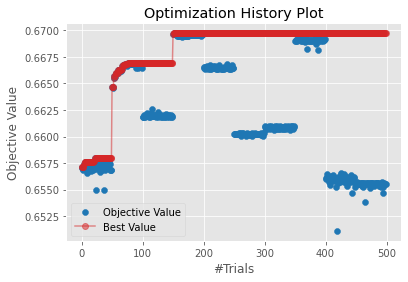

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.679479,0.037395
1,TP,202.300000,11.411982
2,TN,172.300000,11.126046
3,FP,40.700000,10.231216
4,FN,33.900000,6.154492
5,Accuracy,0.833930,0.025812
6,Precision,0.833340,0.037969
7,Sensitivity,0.856120,0.027339
8,Specificity,0.809130,0.046963
9,F1 score,0.844077,0.024980


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.653416,0.660333,0.677432,0.668564,0.646037,0.664824,0.662168,0.673141,0.654957,0.681367,0.664224,0.011155
1,TP,396.000000,409.000000,417.000000,405.000000,400.000000,409.000000,403.000000,402.000000,414.000000,397.000000,405.200000,6.988880
2,TN,356.000000,333.000000,330.000000,338.000000,348.000000,350.000000,343.000000,333.000000,328.000000,341.000000,340.000000,9.285592
3,FP,88.000000,83.000000,93.000000,88.000000,82.000000,73.000000,84.000000,83.000000,88.000000,88.000000,85.000000,5.395471
4,FN,59.000000,74.000000,59.000000,68.000000,69.000000,67.000000,69.000000,81.000000,69.000000,73.000000,68.800000,6.579429
5,Accuracy,0.836485,0.825362,0.830923,0.826474,0.832036,0.844271,0.829811,0.817575,0.825362,0.820912,0.828921,0.007685
6,Precision,0.818182,0.831301,0.817647,0.821501,0.829876,0.848548,0.827515,0.828866,0.824701,0.818557,0.826669,0.009224
7,Sensitivity,0.870330,0.846791,0.876050,0.856237,0.852878,0.859244,0.853814,0.832298,0.857143,0.844681,0.854947,0.012461
8,Specificity,0.801800,0.800500,0.780100,0.793400,0.809300,0.827400,0.803300,0.800500,0.788500,0.794900,0.799970,0.012692
9,F1 score,0.843450,0.838974,0.845842,0.838509,0.841220,0.853862,0.840459,0.830579,0.840609,0.831414,0.840492,0.006697


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,CHEMBL4286867,0,7.25,6.770472,6.820855,6.807082,6.811681,6.727493,6.864597,0.175221
1,CHEMBL3689853,1,6.43,6.518850,6.580664,6.639204,6.579277,6.644410,6.565401,0.073728
2,CHEMBL3827056,2,7.52,8.729277,8.774720,8.773584,8.780487,8.786003,8.560678,0.465773
3,CHEMBL3689883,3,7.70,7.436563,7.415206,7.419130,7.373378,7.421268,7.460924,0.108647
4,CHEMBL2023528,4,7.27,7.607625,7.669848,7.513798,7.355310,7.400442,7.469504,0.140706
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4464975,4487,4.72,5.176844,5.182434,5.128319,5.207729,5.284779,5.116684,0.183476
4488,CHEMBL95747,4488,7.60,6.984038,7.025012,7.189293,7.151203,7.129022,7.179761,0.200971
4489,CHEMBL4072618,4489,5.19,5.157171,5.164853,5.118481,5.171903,5.123584,5.154332,0.025594
4490,CHEMBL2408692,4490,6.36,6.554935,6.462968,6.458560,6.526234,5.966246,6.388157,0.198425


In [38]:
mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.685121,0.024404
1,Accuracy,0.834731,0.017151
2,Precision,0.834629,0.026817
3,Sensitivity,0.855663,0.021652
4,Specificity,0.812030,0.030238
5,F1 score,0.844657,0.016971
6,F1 score (weighted),0.834576,0.017240
7,F1 score (macro),0.833875,0.017247
8,Balanced Accuracy,0.833850,0.017418
9,MCC,0.668863,0.034306


In [39]:
rf_5preds.to_csv('rf_5test_CV_result.csv')
mat_met_optimized_rf.to_csv('mat_met_rf_opt.csv')

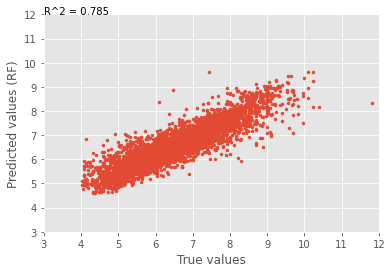

In [40]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (3, 12))
plt.show()

In [41]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.6796 with a standard deviation of 0.0298
RF optimized model r2_score 0.6841 with a standard deviation of 0.0294


In [42]:
import joblib
joblib.dump(rf_reg, "./rf_reg.joblib")
#joblib.dump(optimized_rf, "./optimized_rf.joblib") # fitted to whole training set with last random_state selected
joblib.dump(optimizedCV_rf, "./optimizedCV_rf.joblib")

['./optimizedCV_rf.joblib']

## LGBMRegressor

In [43]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.663239     0.035815
1                    TP       194.000000    10.263203
2                    TN       171.100000     8.723531
3                    FP        41.900000     6.349978
4                    FN        42.200000     5.711587
5              Accuracy         0.812777     0.019324
6             Precision         0.822440     0.025358
7           Sensitivity         0.821092     0.025171
8           Specificity         0.803310     0.029021
9              F1 score         0.821528     0.020437
10  F1 score (weighted)         0.812745     0.019347
11     F1 score (macro)         0.812051     0.019379
12    Balanced Accuracy         0.812205     0.019462
13                  MCC         0.624621     0.038934
14                  NPV         0.802390     0.023526
15              ROC_AUC         0.812205     0.019462
CPU times: user 38.6 s, sys: 132 ms, total: 38.8 s
Wall time: 2.6 s


In [44]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [45]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [46]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 05:40:46,445] A new study created in memory with name: lgbmRegressor
[I 2023-02-17 05:40:51,276] Trial 0 finished with value: 0.675112720226063 and parameters: {'n_estimators': 778, 'learning_rate': 0.09921044350826577, 'max_depth': 11, 'max_bin': 221, 'num_leaves': 144}. Best is trial 0 with value: 0.675112720226063.
[I 2023-02-17 05:40:54,743] Trial 1 finished with value: 0.6678738850391156 and parameters: {'n_estimators': 756, 'learning_rate': 0.18992323196099356, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 80}. Best is trial 0 with value: 0.675112720226063.
[I 2023-02-17 05:41:03,114] Trial 2 finished with value: 0.6425647795501651 and parameters: {'n_estimators': 900, 'learning_rate': 0.017764731310748526, 'max_depth': 6, 'max_bin': 196, 'num_leaves': 39}. Best is trial 0 with value: 0.675112720226063.
[I 2023-02-17 05:41:11,699] Trial 3 finished with value: 0.6681211470874444 and parameters: {'n_estimators': 794, 'learning_rate': 0.031666327914765084, 'max_depth'

[I 2023-02-17 05:43:33,006] Trial 31 finished with value: 0.6744037367047286 and parameters: {'n_estimators': 706, 'learning_rate': 0.04976702553275919, 'max_depth': 12, 'max_bin': 271, 'num_leaves': 529}. Best is trial 20 with value: 0.6766005316495283.
[I 2023-02-17 05:43:42,566] Trial 32 finished with value: 0.6779922538261174 and parameters: {'n_estimators': 751, 'learning_rate': 0.03536050165542186, 'max_depth': 12, 'max_bin': 271, 'num_leaves': 608}. Best is trial 32 with value: 0.6779922538261174.
[I 2023-02-17 05:43:52,435] Trial 33 finished with value: 0.6689957483359311 and parameters: {'n_estimators': 751, 'learning_rate': 0.02707010157744374, 'max_depth': 10, 'max_bin': 284, 'num_leaves': 606}. Best is trial 32 with value: 0.6779922538261174.
[I 2023-02-17 05:43:58,845] Trial 34 finished with value: 0.6725689042347143 and parameters: {'n_estimators': 865, 'learning_rate': 0.07170788088149549, 'max_depth': 11, 'max_bin': 249, 'num_leaves': 674}. Best is trial 32 with value: 

	Number of trials: 50.0
	Best value (r2_score): 0.6792
	Best params:
		n_estimators: 741
		learning_rate: 0.057562431791606014
		max_depth: 11
		max_bin: 266
		num_leaves: 689


In [47]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_0_cat = np.where((y_pred_lgbm_0>= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.665298
1                    TP  377.000000
2                    TN  373.000000
3                    FP   71.000000
4                    FN   78.000000
5              Accuracy    0.834260
6             Precision    0.841518
7           Sensitivity    0.828571
8           Specificity    0.840100
9              F1 score    0.834994
10  F1 score (weighted)    0.834266
11     F1 score (macro)    0.834257
12    Balanced Accuracy    0.834331
13                  MCC    0.668615
14                  NPV    0.827100
15              ROC_AUC    0.834331


In [48]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 05:45:47,853] Trial 50 finished with value: 0.6736989269765725 and parameters: {'n_estimators': 475, 'learning_rate': 0.16279299883594786, 'max_depth': 11, 'max_bin': 291, 'num_leaves': 621}. Best is trial 36 with value: 0.6792151005138968.
[I 2023-02-17 05:45:52,680] Trial 51 finished with value: 0.6753306314513534 and parameters: {'n_estimators': 523, 'learning_rate': 0.13420239813345208, 'max_depth': 11, 'max_bin': 291, 'num_leaves': 644}. Best is trial 36 with value: 0.6792151005138968.
[I 2023-02-17 05:45:58,247] Trial 52 finished with value: 0.6771947859999427 and parameters: {'n_estimators': 395, 'learning_rate': 0.11551332634211546, 'max_depth': 12, 'max_bin': 265, 'num_leaves': 566}. Best is trial 36 with value: 0.6792151005138968.
[I 2023-02-17 05:46:02,721] Trial 53 finished with value: 0.6755687711378006 and parameters: {'n_estimators': 306, 'learning_rate': 0.12013490735259412, 'max_depth': 12, 'max_bin': 265, 'num_leaves': 579}. Best is trial 36 with value: 

[I 2023-02-17 05:48:34,912] Trial 81 finished with value: 0.6807255681661799 and parameters: {'n_estimators': 883, 'learning_rate': 0.10310506794850463, 'max_depth': 10, 'max_bin': 299, 'num_leaves': 371}. Best is trial 76 with value: 0.6840252980239433.
[I 2023-02-17 05:48:40,550] Trial 82 finished with value: 0.6817487576121151 and parameters: {'n_estimators': 869, 'learning_rate': 0.10258563285401393, 'max_depth': 9, 'max_bin': 300, 'num_leaves': 367}. Best is trial 76 with value: 0.6840252980239433.
[I 2023-02-17 05:48:45,366] Trial 83 finished with value: 0.6778641766858182 and parameters: {'n_estimators': 866, 'learning_rate': 0.1023312987826321, 'max_depth': 9, 'max_bin': 300, 'num_leaves': 373}. Best is trial 76 with value: 0.6840252980239433.
[I 2023-02-17 05:48:51,749] Trial 84 finished with value: 0.678467936930477 and parameters: {'n_estimators': 900, 'learning_rate': 0.09002709155753047, 'max_depth': 10, 'max_bin': 298, 'num_leaves': 299}. Best is trial 76 with value: 0.68

	Number of trials: 100.0
	Best value (r2_score): 0.6840
	Best params:
		n_estimators: 779
		learning_rate: 0.03857672323037514
		max_depth: 11
		max_bin: 285
		num_leaves: 537


In [49]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_1_cat = np.where((y_pred_lgbm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.665298    0.676487
1                    TP  377.000000  387.000000
2                    TN  373.000000  343.000000
3                    FP   71.000000   73.000000
4                    FN   78.000000   96.000000
5              Accuracy    0.834260    0.812013
6             Precision    0.841518    0.841304
7           Sensitivity    0.828571    0.801242
8           Specificity    0.840100    0.824500
9              F1 score    0.834994    0.820785
10  F1 score (weighted)    0.834266    0.812249
11     F1 score (macro)    0.834257    0.811562
12    Balanced Accuracy    0.834331    0.812881
13                  MCC    0.668615    0.624192
14                  NPV    0.827100    0.781300
15              ROC_AUC    0.834331    0.812881


In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 05:50:26,078] Trial 100 finished with value: 0.678936779818315 and parameters: {'n_estimators': 845, 'learning_rate': 0.0950801419258824, 'max_depth': 9, 'max_bin': 293, 'num_leaves': 411}. Best is trial 76 with value: 0.6840252980239433.
[I 2023-02-17 05:50:31,654] Trial 101 finished with value: 0.6783370886727816 and parameters: {'n_estimators': 891, 'learning_rate': 0.08588507406243572, 'max_depth': 8, 'max_bin': 293, 'num_leaves': 467}. Best is trial 76 with value: 0.6840252980239433.
[I 2023-02-17 05:50:38,287] Trial 102 finished with value: 0.6841701186532203 and parameters: {'n_estimators': 883, 'learning_rate': 0.07127269544987658, 'max_depth': 10, 'max_bin': 300, 'num_leaves': 481}. Best is trial 102 with value: 0.6841701186532203.
[I 2023-02-17 05:50:45,917] Trial 103 finished with value: 0.6827542206253279 and parameters: {'n_estimators': 854, 'learning_rate': 0.07171381772988254, 'max_depth': 9, 'max_bin': 300, 'num_leaves': 449}. Best is trial 102 with value:

[I 2023-02-17 05:54:28,697] Trial 131 finished with value: 0.6834961633919445 and parameters: {'n_estimators': 756, 'learning_rate': 0.04314206528517416, 'max_depth': 10, 'max_bin': 176, 'num_leaves': 475}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:54:36,495] Trial 132 finished with value: 0.6749993232942944 and parameters: {'n_estimators': 752, 'learning_rate': 0.04229785364738951, 'max_depth': 10, 'max_bin': 174, 'num_leaves': 491}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:54:48,857] Trial 133 finished with value: 0.6774350731475556 and parameters: {'n_estimators': 767, 'learning_rate': 0.02437459548001957, 'max_depth': 11, 'max_bin': 194, 'num_leaves': 471}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:54:56,497] Trial 134 finished with value: 0.6816701131860639 and parameters: {'n_estimators': 783, 'learning_rate': 0.05643629268195372, 'max_depth': 10, 'max_bin': 184, 'num_leaves': 539}. Best is trial 123 with

	Number of trials: 150.0
	Best value (r2_score): 0.6894
	Best params:
		n_estimators: 799
		learning_rate: 0.04811474628046
		max_depth: 10
		max_bin: 182
		num_leaves: 496


In [51]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_2_cat = np.where((y_pred_lgbm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.665298    0.676487    0.697708
1                    TP  377.000000  387.000000  413.000000
2                    TN  373.000000  343.000000  342.000000
3                    FP   71.000000   73.000000   81.000000
4                    FN   78.000000   96.000000   63.000000
5              Accuracy    0.834260    0.812013    0.839822
6             Precision    0.841518    0.841304    0.836032
7           Sensitivity    0.828571    0.801242    0.867647
8           Specificity    0.840100    0.824500    0.808500
9              F1 score    0.834994    0.820785    0.851546
10  F1 score (weighted)    0.834266    0.812249    0.839567
11     F1 score (macro)    0.834257    0.811562    0.838817
12    Balanced Accuracy    0.834331    0.812881    0.838079
13                  MCC    0.668615    0.624192    0.678314
14                  NPV    0.827100    0.781300    0.844400
15              ROC_AUC    0.834331    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 05:56:55,651] Trial 150 finished with value: 0.6851436982809034 and parameters: {'n_estimators': 654, 'learning_rate': 0.055478623271072766, 'max_depth': 11, 'max_bin': 157, 'num_leaves': 608}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:57:04,584] Trial 151 finished with value: 0.6861996405524856 and parameters: {'n_estimators': 654, 'learning_rate': 0.05485774583312016, 'max_depth': 11, 'max_bin': 157, 'num_leaves': 582}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:57:12,659] Trial 152 finished with value: 0.6846643320602197 and parameters: {'n_estimators': 644, 'learning_rate': 0.055605895262674156, 'max_depth': 11, 'max_bin': 155, 'num_leaves': 599}. Best is trial 123 with value: 0.6893565917321014.
[I 2023-02-17 05:57:20,782] Trial 153 finished with value: 0.686209488163444 and parameters: {'n_estimators': 654, 'learning_rate': 0.05427093732221989, 'max_depth': 11, 'max_bin': 157, 'num_leaves': 609}. Best is trial 123 wit

[I 2023-02-17 06:00:46,776] Trial 181 finished with value: 0.686876963489185 and parameters: {'n_estimators': 689, 'learning_rate': 0.063175703168476, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 534}. Best is trial 164 with value: 0.6896201597307303.
[I 2023-02-17 06:00:54,603] Trial 182 finished with value: 0.6855797458181394 and parameters: {'n_estimators': 689, 'learning_rate': 0.06374672100499543, 'max_depth': 12, 'max_bin': 206, 'num_leaves': 532}. Best is trial 164 with value: 0.6896201597307303.
[I 2023-02-17 06:01:02,681] Trial 183 finished with value: 0.6880421790929836 and parameters: {'n_estimators': 706, 'learning_rate': 0.06097883250558945, 'max_depth': 12, 'max_bin': 198, 'num_leaves': 530}. Best is trial 164 with value: 0.6896201597307303.
[I 2023-02-17 06:01:09,927] Trial 184 finished with value: 0.6825622527080196 and parameters: {'n_estimators': 708, 'learning_rate': 0.06395702494684449, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 541}. Best is trial 164 with va

	Number of trials: 200.0
	Best value (r2_score): 0.6902
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [53]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_3_cat = np.where((y_pred_lgbm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.665298    0.676487    0.697708    0.684076
1                    TP  377.000000  387.000000  413.000000  387.000000
2                    TN  373.000000  343.000000  342.000000  354.000000
3                    FP   71.000000   73.000000   81.000000   72.000000
4                    FN   78.000000   96.000000   63.000000   86.000000
5              Accuracy    0.834260    0.812013    0.839822    0.824249
6             Precision    0.841518    0.841304    0.836032    0.843137
7           Sensitivity    0.828571    0.801242    0.867647    0.818182
8           Specificity    0.840100    0.824500    0.808500    0.831000
9              F1 score    0.834994    0.820785    0.851546    0.830472
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012
12    Balanced Accuracy    0.834331    0.812881    0.838079    0

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:03:07,028] Trial 200 finished with value: 0.6859511497570535 and parameters: {'n_estimators': 706, 'learning_rate': 0.06132227670711708, 'max_depth': 12, 'max_bin': 196, 'num_leaves': 571}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:03:13,420] Trial 201 finished with value: 0.6837037697988789 and parameters: {'n_estimators': 728, 'learning_rate': 0.07230189886585353, 'max_depth': 12, 'max_bin': 219, 'num_leaves': 517}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:03:18,411] Trial 202 finished with value: 0.6824376987867623 and parameters: {'n_estimators': 744, 'learning_rate': 0.08231454582755346, 'max_depth': 12, 'max_bin': 203, 'num_leaves': 540}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:03:25,469] Trial 203 finished with value: 0.6822665192909122 and parameters: {'n_estimators': 751, 'learning_rate': 0.07004056698323881, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 527}. Best is trial 187 with

[I 2023-02-17 06:06:53,128] Trial 231 finished with value: 0.6830378907152049 and parameters: {'n_estimators': 722, 'learning_rate': 0.0697363152548285, 'max_depth': 11, 'max_bin': 205, 'num_leaves': 552}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:06:59,938] Trial 232 finished with value: 0.6839093321611405 and parameters: {'n_estimators': 728, 'learning_rate': 0.07282334478957699, 'max_depth': 11, 'max_bin': 203, 'num_leaves': 562}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:07:05,670] Trial 233 finished with value: 0.6796782359709684 and parameters: {'n_estimators': 785, 'learning_rate': 0.07894694088532102, 'max_depth': 11, 'max_bin': 199, 'num_leaves': 514}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:07:11,404] Trial 234 finished with value: 0.6786854641262726 and parameters: {'n_estimators': 740, 'learning_rate': 0.06885502894635648, 'max_depth': 11, 'max_bin': 209, 'num_leaves': 591}. Best is trial 187 with 

	Number of trials: 250.0
	Best value (r2_score): 0.6902
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [55]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_4_cat = np.where((y_pred_lgbm_4 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:09:14,650] Trial 250 finished with value: 0.677804399818378 and parameters: {'n_estimators': 630, 'learning_rate': 0.05181769938267676, 'max_depth': 11, 'max_bin': 162, 'num_leaves': 603}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:09:24,028] Trial 251 finished with value: 0.6773765881707163 and parameters: {'n_estimators': 794, 'learning_rate': 0.04064060690112253, 'max_depth': 11, 'max_bin': 169, 'num_leaves': 590}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:09:28,338] Trial 252 finished with value: 0.6436174082170605 and parameters: {'n_estimators': 708, 'learning_rate': 0.05663994966726927, 'max_depth': 4, 'max_bin': 236, 'num_leaves': 574}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:09:36,315] Trial 253 finished with value: 0.6768128191740658 and parameters: {'n_estimators': 650, 'learning_rate': 0.050303413037865154, 'max_depth': 11, 'max_bin': 197, 'num_leaves': 626}. Best is trial 187 with 

[I 2023-02-17 06:13:02,046] Trial 281 finished with value: 0.6805036685253664 and parameters: {'n_estimators': 670, 'learning_rate': 0.06659917755936925, 'max_depth': 11, 'max_bin': 194, 'num_leaves': 593}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:13:08,993] Trial 282 finished with value: 0.6779102137144362 and parameters: {'n_estimators': 743, 'learning_rate': 0.06134235734776732, 'max_depth': 11, 'max_bin': 171, 'num_leaves': 621}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:13:18,347] Trial 283 finished with value: 0.6764915277076049 and parameters: {'n_estimators': 695, 'learning_rate': 0.04955230082341185, 'max_depth': 10, 'max_bin': 201, 'num_leaves': 535}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:13:27,142] Trial 284 finished with value: 0.6789694481114931 and parameters: {'n_estimators': 620, 'learning_rate': 0.05654107302746379, 'max_depth': 11, 'max_bin': 206, 'num_leaves': 564}. Best is trial 187 with

	Number of trials: 300.0
	Best value (r2_score): 0.6902
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [57]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_5_cat = np.where((y_pred_lgbm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:15:34,201] Trial 300 finished with value: 0.6780569616169377 and parameters: {'n_estimators': 753, 'learning_rate': 0.04835416550079981, 'max_depth': 10, 'max_bin': 206, 'num_leaves': 525}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:15:42,419] Trial 301 finished with value: 0.6854957129633397 and parameters: {'n_estimators': 732, 'learning_rate': 0.06250988550007719, 'max_depth': 12, 'max_bin': 198, 'num_leaves': 545}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:15:49,566] Trial 302 finished with value: 0.6823280493878654 and parameters: {'n_estimators': 681, 'learning_rate': 0.06878172281704575, 'max_depth': 11, 'max_bin': 165, 'num_leaves': 582}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:15:57,679] Trial 303 finished with value: 0.6803996690539166 and parameters: {'n_estimators': 662, 'learning_rate': 0.052555570476690475, 'max_depth': 11, 'max_bin': 150, 'num_leaves': 561}. Best is trial 187 wit

[I 2023-02-17 06:18:54,197] Trial 331 finished with value: 0.6761660810473055 and parameters: {'n_estimators': 706, 'learning_rate': 0.04601736982138191, 'max_depth': 10, 'max_bin': 224, 'num_leaves': 562}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:19:00,152] Trial 332 finished with value: 0.6782712875030995 and parameters: {'n_estimators': 818, 'learning_rate': 0.07600483279142987, 'max_depth': 11, 'max_bin': 197, 'num_leaves': 598}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:19:07,142] Trial 333 finished with value: 0.6802660649279775 and parameters: {'n_estimators': 758, 'learning_rate': 0.05274977089285111, 'max_depth': 12, 'max_bin': 232, 'num_leaves': 551}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:19:14,396] Trial 334 finished with value: 0.6810623313726518 and parameters: {'n_estimators': 674, 'learning_rate': 0.060254012741224675, 'max_depth': 11, 'max_bin': 211, 'num_leaves': 569}. Best is trial 187 wit

	Number of trials: 350.0
	Best value (r2_score): 0.690157
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [59]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_6_cat = np.where((y_pred_lgbm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:21:13,915] Trial 350 finished with value: 0.6839852697217117 and parameters: {'n_estimators': 695, 'learning_rate': 0.0592148085872625, 'max_depth': 11, 'max_bin': 204, 'num_leaves': 385}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:21:22,056] Trial 351 finished with value: 0.6845148941129162 and parameters: {'n_estimators': 766, 'learning_rate': 0.052341198265722186, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 512}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:21:28,392] Trial 352 finished with value: 0.6842880346199786 and parameters: {'n_estimators': 729, 'learning_rate': 0.08050893422001745, 'max_depth': 11, 'max_bin': 197, 'num_leaves': 564}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:21:33,472] Trial 353 finished with value: 0.679128705282659 and parameters: {'n_estimators': 625, 'learning_rate': 0.07248872419311943, 'max_depth': 7, 'max_bin': 157, 'num_leaves': 611}. Best is trial 187 with v

[I 2023-02-17 06:25:21,132] Trial 381 finished with value: 0.688948116573035 and parameters: {'n_estimators': 788, 'learning_rate': 0.021888863037258413, 'max_depth': 12, 'max_bin': 159, 'num_leaves': 400}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:25:30,055] Trial 382 finished with value: 0.6868708981307887 and parameters: {'n_estimators': 811, 'learning_rate': 0.03869871280878874, 'max_depth': 12, 'max_bin': 159, 'num_leaves': 393}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:25:40,542] Trial 383 finished with value: 0.6867252840340493 and parameters: {'n_estimators': 793, 'learning_rate': 0.031071976661754517, 'max_depth': 12, 'max_bin': 156, 'num_leaves': 416}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:25:55,379] Trial 384 finished with value: 0.6853604972004701 and parameters: {'n_estimators': 820, 'learning_rate': 0.016242981460268757, 'max_depth': 12, 'max_bin': 151, 'num_leaves': 400}. Best is trial 187 wi

	Number of trials: 400.0
	Best value (r2_score): 0.6901570
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [61]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_7_cat = np.where((y_pred_lgbm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:28:59,169] Trial 400 finished with value: 0.6729890719570946 and parameters: {'n_estimators': 852, 'learning_rate': 0.025794928872415725, 'max_depth': 12, 'max_bin': 209, 'num_leaves': 391}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:29:11,388] Trial 401 finished with value: 0.6722713697610188 and parameters: {'n_estimators': 856, 'learning_rate': 0.025288414509698407, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 385}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:29:25,351] Trial 402 finished with value: 0.674379403069187 and parameters: {'n_estimators': 856, 'learning_rate': 0.020131560911274785, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 322}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:29:40,983] Trial 403 finished with value: 0.6690987384803891 and parameters: {'n_estimators': 873, 'learning_rate': 0.01302241171775836, 'max_depth': 12, 'max_bin': 214, 'num_leaves': 420}. Best is trial 187 wi

[I 2023-02-17 06:35:11,725] Trial 431 finished with value: 0.6790914039637246 and parameters: {'n_estimators': 868, 'learning_rate': 0.044216006940535325, 'max_depth': 12, 'max_bin': 155, 'num_leaves': 430}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:35:16,812] Trial 432 finished with value: 0.6398154110652869 and parameters: {'n_estimators': 657, 'learning_rate': 0.03666138190722279, 'max_depth': 5, 'max_bin': 205, 'num_leaves': 665}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:35:24,321] Trial 433 finished with value: 0.6756600095168269 and parameters: {'n_estimators': 691, 'learning_rate': 0.06783667899892537, 'max_depth': 12, 'max_bin': 211, 'num_leaves': 520}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:35:31,175] Trial 434 finished with value: 0.6705862411558255 and parameters: {'n_estimators': 533, 'learning_rate': 0.06524590348580213, 'max_depth': 11, 'max_bin': 165, 'num_leaves': 545}. Best is trial 187 with

	Number of trials: 450.0
	Best value (r2_score): 0.69015697
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [63]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_8_cat = np.where((y_pred_lgbm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

In [64]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:37:49,125] Trial 450 finished with value: 0.6758453118284062 and parameters: {'n_estimators': 780, 'learning_rate': 0.05606218654588787, 'max_depth': 11, 'max_bin': 166, 'num_leaves': 561}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:38:00,506] Trial 451 finished with value: 0.6739099383707216 and parameters: {'n_estimators': 659, 'learning_rate': 0.03380331349527867, 'max_depth': 12, 'max_bin': 202, 'num_leaves': 695}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:38:10,785] Trial 452 finished with value: 0.6655240412918318 and parameters: {'n_estimators': 591, 'learning_rate': 0.022829981157401324, 'max_depth': 11, 'max_bin': 152, 'num_leaves': 541}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:38:16,615] Trial 453 finished with value: 0.6721975647624211 and parameters: {'n_estimators': 337, 'learning_rate': 0.06613343389115273, 'max_depth': 12, 'max_bin': 208, 'num_leaves': 587}. Best is trial 187 wit

[I 2023-02-17 06:42:11,581] Trial 481 finished with value: 0.6766807819876783 and parameters: {'n_estimators': 620, 'learning_rate': 0.06578565789407176, 'max_depth': 11, 'max_bin': 199, 'num_leaves': 540}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:42:18,412] Trial 482 finished with value: 0.6657704039737077 and parameters: {'n_estimators': 865, 'learning_rate': 0.05420685769380061, 'max_depth': 7, 'max_bin': 154, 'num_leaves': 415}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:42:29,258] Trial 483 finished with value: 0.6785375340588595 and parameters: {'n_estimators': 750, 'learning_rate': 0.040426442740228656, 'max_depth': 12, 'max_bin': 214, 'num_leaves': 399}. Best is trial 187 with value: 0.6901569662717765.
[I 2023-02-17 06:42:37,085] Trial 484 finished with value: 0.6782033425101199 and parameters: {'n_estimators': 827, 'learning_rate': 0.059753206537665506, 'max_depth': 11, 'max_bin': 202, 'num_leaves': 528}. Best is trial 187 wit

	Number of trials: 500.0
	Best value (r2_score): 0.690156966
	Best params:
		n_estimators: 699
		learning_rate: 0.06968993674967647
		max_depth: 12
		max_bin: 202
		num_leaves: 556


In [65]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_9_cat = np.where((y_pred_lgbm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.665298    0.676487    0.697708    0.684076   
1                    TP  377.000000  387.000000  413.000000  387.000000   
2                    TN  373.000000  343.000000  342.000000  354.000000   
3                    FP   71.000000   73.000000   81.000000   72.000000   
4                    FN   78.000000   96.000000   63.000000   86.000000   
5              Accuracy    0.834260    0.812013    0.839822    0.824249   
6             Precision    0.841518    0.841304    0.836032    0.843137   
7           Sensitivity    0.828571    0.801242    0.867647    0.818182   
8           Specificity    0.840100    0.824500    0.808500    0.831000   
9              F1 score    0.834994    0.820785    0.851546    0.830472   
10  F1 score (weighted)    0.834266    0.812249    0.839567    0.824350   
11     F1 score (macro)    0.834257    0.811562    0.838817    0.824012   
12    Balanced Accuracy  

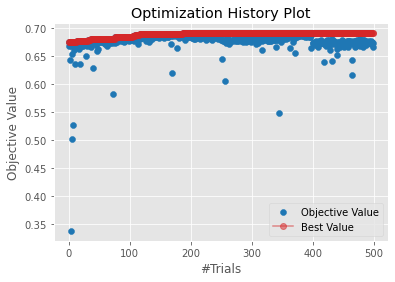

In [66]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

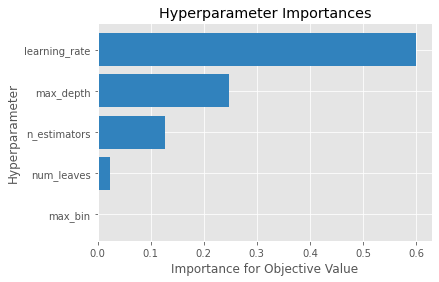

In [67]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [68]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.697969     0.035125
1                    TP       197.500000    11.787470
2                    TN       173.700000     9.877584
3                    FP        39.300000     7.587270
4                    FN        38.700000     7.484057
5              Accuracy         0.826360     0.026869
6             Precision         0.834108     0.030552
7           Sensitivity         0.835831     0.033150
8           Specificity         0.815490     0.035580
9              F1 score         0.834691     0.027440
10  F1 score (weighted)         0.826291     0.026904
11     F1 score (macro)         0.825607     0.027092
12    Balanced Accuracy         0.825658     0.027160
13                  MCC         0.651824     0.054374
14                  NPV         0.818230     0.032056
15              ROC_AUC         0.825658     0.027160


In [69]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.665298,0.676487,0.697708,0.684076,0.650299,0.681476,0.707530,0.679296,0.669725,0.712637,0.682453,0.019183
1,TP,377.000000,387.000000,413.000000,387.000000,385.000000,392.000000,401.000000,394.000000,394.000000,408.000000,393.800000,10.942273
2,TN,373.000000,343.000000,342.000000,354.000000,357.000000,360.000000,355.000000,330.000000,337.000000,351.000000,350.200000,12.479316
3,FP,71.000000,73.000000,81.000000,72.000000,73.000000,63.000000,72.000000,86.000000,79.000000,78.000000,74.800000,6.390966
4,FN,78.000000,96.000000,63.000000,86.000000,84.000000,84.000000,71.000000,89.000000,89.000000,62.000000,80.200000,11.467829
5,Accuracy,0.834260,0.812013,0.839822,0.824249,0.825362,0.836485,0.840934,0.805339,0.813126,0.844271,0.827586,0.013714
6,Precision,0.841518,0.841304,0.836032,0.843137,0.840611,0.861538,0.847780,0.820833,0.832981,0.839506,0.840524,0.010374
7,Sensitivity,0.828571,0.801242,0.867647,0.818182,0.820896,0.823529,0.849576,0.815735,0.815735,0.868085,0.830920,0.022956
8,Specificity,0.840100,0.824500,0.808500,0.831000,0.830200,0.851100,0.831400,0.793300,0.810100,0.818200,0.823840,0.016817
9,F1 score,0.834994,0.820785,0.851546,0.830472,0.830636,0.842105,0.848677,0.818276,0.824268,0.853556,0.835532,0.012864


In [70]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,CHEMBL4286867,0,7.25,7.061109,7.128216,6.904595,7.081291,7.047927,7.078856,0.102771
1,CHEMBL3689853,1,6.43,6.623541,6.824560,6.457572,6.613510,6.708559,6.609624,0.136369
2,CHEMBL3827056,2,7.52,9.014687,8.888470,8.851263,8.746736,8.625055,8.607702,0.501085
3,CHEMBL3689883,3,7.70,7.380153,7.400202,7.412950,7.322333,7.421699,7.439556,0.120883
4,CHEMBL2023528,4,7.27,7.286109,7.420156,7.576086,7.212505,7.241474,7.334388,0.126319
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4464975,4487,4.72,5.158414,4.985077,5.165894,5.066597,4.943778,5.006627,0.151971
4488,CHEMBL95747,4488,7.60,7.122615,7.123870,7.054640,7.041531,7.025064,7.161287,0.199848
4489,CHEMBL4072618,4489,5.19,4.924537,5.039298,5.178789,5.049264,5.131079,5.085494,0.092247
4490,CHEMBL2408692,4490,6.36,6.407742,6.494178,6.452008,6.657210,5.458403,6.304924,0.389820


In [71]:
mat_met_optimized_lgbm.to_csv('mat_met_lgbm_opt.csv')
lgbm_5preds.to_csv('lgbm_5test_CV_result.csv')

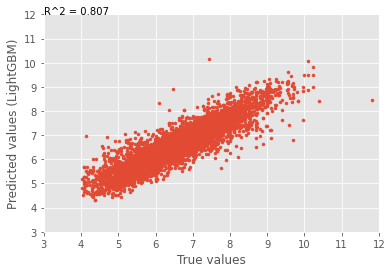

In [72]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (3, 12))
plt.show()

In [73]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.6680 with a standard deviation of 0.0370
LightGBM optimized model r2_score 0.7003 with a standard deviation of 0.0320


In [74]:
joblib.dump(lgbm_reg, "./lgbm_reg.joblib")
#joblib.dump(optimized_lgbm, "./optimized_lgbm.joblib")
joblib.dump(optimizedCV_lgbm, "./optimizedCV_lgbm.joblib") 
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_lgbm.joblib']

## XGBoost

In [75]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.646608     0.035959
1                    TP       189.900000     9.791720
2                    TN       172.600000     9.167576
3                    FP        40.400000     7.336363
4                    FN        46.300000     5.850926
5              Accuracy         0.806990     0.022677
6             Precision         0.824755     0.029509
7           Sensitivity         0.803790     0.025493
8           Specificity         0.810450     0.032703
9              F1 score         0.813890     0.023227
10  F1 score (weighted)         0.807059     0.022694
11     F1 score (macro)         0.806478     0.022775
12    Balanced Accuracy         0.807114     0.022903
13                  MCC         0.613757     0.045576
14                  NPV         0.788530     0.024919
15              ROC_AUC         0.807114     0.022903
CPU times: user 2h 34min 27s, sys: 4.91 s, total: 2h 34min 32s
Wall time: 6min 42s

In [76]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [77]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [78]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 06:53:01,158] A new study created in memory with name: XGBRegressor
[I 2023-02-17 06:53:03,365] Trial 0 finished with value: 0.3933044590210316 and parameters: {'n_estimators': 110, 'eta': 0.0324185013819833, 'max_depth': 6, 'alpha': 0.6084, 'lambda': 23.81515403566228, 'max_bin': 456}. Best is trial 0 with value: 0.3933044590210316.
[I 2023-02-17 06:53:18,363] Trial 1 finished with value: 0.6706421978846683 and parameters: {'n_estimators': 448, 'eta': 0.029788046074910094, 'max_depth': 9, 'alpha': 0.0636, 'lambda': 10.88362860208099, 'max_bin': 291}. Best is trial 1 with value: 0.6706421978846683.
[I 2023-02-17 06:53:36,398] Trial 2 finished with value: 0.6799466856044281 and parameters: {'n_estimators': 837, 'eta': 0.0489358236101397, 'max_depth': 7, 'alpha': 0.0635, 'lambda': 21.723505655577757, 'max_bin': 273}. Best is trial 2 with value: 0.6799466856044281.
[I 2023-02-17 06:53:50,517] Trial 3 finished with value: 0.6571482523531347 and parameters: {'n_estimators': 71

[I 2023-02-17 07:03:21,070] Trial 29 finished with value: 0.6816714185597629 and parameters: {'n_estimators': 645, 'eta': 0.033951962129802636, 'max_depth': 9, 'alpha': 0.5656, 'lambda': 24.54820906129855, 'max_bin': 391}. Best is trial 14 with value: 0.6867425306792625.
[I 2023-02-17 07:03:35,955] Trial 30 finished with value: 0.6779162729156475 and parameters: {'n_estimators': 410, 'eta': 0.04887872289827061, 'max_depth': 10, 'alpha': 0.6776, 'lambda': 22.079614223551864, 'max_bin': 279}. Best is trial 14 with value: 0.6867425306792625.
[I 2023-02-17 07:04:07,386] Trial 31 finished with value: 0.6857034132433294 and parameters: {'n_estimators': 806, 'eta': 0.050130120042862394, 'max_depth': 11, 'alpha': 0.7516, 'lambda': 28.057862778218603, 'max_bin': 394}. Best is trial 14 with value: 0.6867425306792625.
[I 2023-02-17 07:04:41,408] Trial 32 finished with value: 0.6838294795252668 and parameters: {'n_estimators': 780, 'eta': 0.030925509658017495, 'max_depth': 11, 'alpha': 0.8997, 'la

	Number of trials: 50.0
	Best value (r2_score): 0.6872
	Best params:
		n_estimators: 803
		eta: 0.0493516347528431
		max_depth: 10
		alpha: 0.437
		lambda: 29.310301632685523
		max_bin: 362


In [79]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
y_pred_xgb_0_cat = np.where((y_pred_xgb_0 >= 6.6), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.683009
1                    TP  385.000000
2                    TN  373.000000
3                    FP   71.000000
4                    FN   70.000000
5              Accuracy    0.843159
6             Precision    0.844298
7           Sensitivity    0.846154
8           Specificity    0.840100
9              F1 score    0.845225
10  F1 score (weighted)    0.843157
11     F1 score (macro)    0.843131
12    Balanced Accuracy    0.843122
13                  MCC    0.686264
14                  NPV    0.842000
15              ROC_AUC    0.843122


In [80]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 07:12:32,191] Trial 50 finished with value: 0.6918179401348288 and parameters: {'n_estimators': 678, 'eta': 0.06501879732566876, 'max_depth': 10, 'alpha': 0.4495, 'lambda': 29.99590391766522, 'max_bin': 422}. Best is trial 50 with value: 0.6918179401348288.
[I 2023-02-17 07:12:59,532] Trial 51 finished with value: 0.6931828127033265 and parameters: {'n_estimators': 679, 'eta': 0.04585326886760678, 'max_depth': 10, 'alpha': 0.44320000000000004, 'lambda': 30.274823458625328, 'max_bin': 439}. Best is trial 51 with value: 0.6931828127033265.
[I 2023-02-17 07:13:19,681] Trial 52 finished with value: 0.6895220884456548 and parameters: {'n_estimators': 685, 'eta': 0.06388160759565564, 'max_depth': 9, 'alpha': 0.4292, 'lambda': 30.315867173782124, 'max_bin': 445}. Best is trial 51 with value: 0.6931828127033265.
[I 2023-02-17 07:13:41,153] Trial 53 finished with value: 0.6928414335679727 and parameters: {'n_estimators': 664, 'eta': 0.06350604704831454, 'max_depth': 9, 'alpha': 0.

[I 2023-02-17 07:20:48,664] Trial 79 finished with value: 0.6911240061173898 and parameters: {'n_estimators': 706, 'eta': 0.07192533012329191, 'max_depth': 10, 'alpha': 0.4359, 'lambda': 31.601377632963235, 'max_bin': 415}. Best is trial 51 with value: 0.6931828127033265.
[I 2023-02-17 07:21:11,289] Trial 80 finished with value: 0.6909901666844849 and parameters: {'n_estimators': 706, 'eta': 0.07125661453648656, 'max_depth': 10, 'alpha': 0.43860000000000005, 'lambda': 31.52020243480227, 'max_bin': 400}. Best is trial 51 with value: 0.6931828127033265.
[I 2023-02-17 07:21:32,502] Trial 81 finished with value: 0.6905438711864591 and parameters: {'n_estimators': 705, 'eta': 0.07421371599175755, 'max_depth': 10, 'alpha': 0.43, 'lambda': 31.41012828903905, 'max_bin': 416}. Best is trial 51 with value: 0.6931828127033265.
[I 2023-02-17 07:21:37,865] Trial 82 finished with value: 0.639117340777059 and parameters: {'n_estimators': 130, 'eta': 0.05972873216623293, 'max_depth': 10, 'alpha': 0.45

	Number of trials: 100.0
	Best value (r2_score): 0.6942
	Best params:
		n_estimators: 729
		eta: 0.08179573134756025
		max_depth: 10
		alpha: 0.36000000000000004
		lambda: 28.49504598331064
		max_bin: 420


In [81]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_1_cat = np.where((y_pred_xgb_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.683009    0.703984
1                    TP  385.000000  407.000000
2                    TN  373.000000  343.000000
3                    FP   71.000000   73.000000
4                    FN   70.000000   76.000000
5              Accuracy    0.843159    0.834260
6             Precision    0.844298    0.847917
7           Sensitivity    0.846154    0.842650
8           Specificity    0.840100    0.824500
9              F1 score    0.845225    0.845275
10  F1 score (weighted)    0.843157    0.834300
11     F1 score (macro)    0.843131    0.833416
12    Balanced Accuracy    0.843122    0.833585
13                  MCC    0.686264    0.666851
14                  NPV    0.842000    0.818600
15              ROC_AUC    0.843122    0.833585


In [82]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 07:28:45,726] Trial 100 finished with value: 0.7015417450179974 and parameters: {'n_estimators': 752, 'eta': 0.06690975119101743, 'max_depth': 9, 'alpha': 0.2737, 'lambda': 37.62009230106907, 'max_bin': 386}. Best is trial 100 with value: 0.7015417450179974.
[I 2023-02-17 07:29:10,972] Trial 101 finished with value: 0.6986022220691381 and parameters: {'n_estimators': 753, 'eta': 0.06638121055587809, 'max_depth': 9, 'alpha': 0.2101, 'lambda': 34.20873814279258, 'max_bin': 370}. Best is trial 100 with value: 0.7015417450179974.
[I 2023-02-17 07:29:36,968] Trial 102 finished with value: 0.6995692989274334 and parameters: {'n_estimators': 804, 'eta': 0.06720113338409964, 'max_depth': 9, 'alpha': 0.18330000000000002, 'lambda': 38.9555799285147, 'max_bin': 363}. Best is trial 100 with value: 0.7015417450179974.
[I 2023-02-17 07:30:04,033] Trial 103 finished with value: 0.6997204320036376 and parameters: {'n_estimators': 793, 'eta': 0.06550885036921923, 'max_depth': 9, 'alpha': 

[I 2023-02-17 07:42:16,334] Trial 129 finished with value: 0.6996807052497354 and parameters: {'n_estimators': 813, 'eta': 0.06232687803233269, 'max_depth': 9, 'alpha': 0.1102, 'lambda': 35.04444697379234, 'max_bin': 336}. Best is trial 124 with value: 0.7021007319355244.
[I 2023-02-17 07:42:42,940] Trial 130 finished with value: 0.7016251904565507 and parameters: {'n_estimators': 840, 'eta': 0.06226466206084178, 'max_depth': 9, 'alpha': 0.11030000000000001, 'lambda': 34.952879904648505, 'max_bin': 344}. Best is trial 124 with value: 0.7021007319355244.
[I 2023-02-17 07:43:10,936] Trial 131 finished with value: 0.700529257693196 and parameters: {'n_estimators': 837, 'eta': 0.06201166855566055, 'max_depth': 9, 'alpha': 0.11670000000000001, 'lambda': 36.50814192361044, 'max_bin': 336}. Best is trial 124 with value: 0.7021007319355244.
[I 2023-02-17 07:43:38,634] Trial 132 finished with value: 0.6968813831963028 and parameters: {'n_estimators': 841, 'eta': 0.06501392349761387, 'max_depth'

	Number of trials: 150.0
	Best value (r2_score): 0.7034
	Best params:
		n_estimators: 836
		eta: 0.06181888233125367
		max_depth: 9
		alpha: 0.054900000000000004
		lambda: 34.38702115768485
		max_bin: 345


In [83]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_2_cat = np.where((y_pred_xgb_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.683009    0.703984    0.706733
1                    TP  385.000000  407.000000  407.000000
2                    TN  373.000000  343.000000  332.000000
3                    FP   71.000000   73.000000   91.000000
4                    FN   70.000000   76.000000   69.000000
5              Accuracy    0.843159    0.834260    0.822024
6             Precision    0.844298    0.847917    0.817269
7           Sensitivity    0.846154    0.842650    0.855042
8           Specificity    0.840100    0.824500    0.784900
9              F1 score    0.845225    0.845275    0.835729
10  F1 score (weighted)    0.843157    0.834300    0.821659
11     F1 score (macro)    0.843131    0.833416    0.820777
12    Balanced Accuracy    0.843122    0.833585    0.819956
13                  MCC    0.686264    0.666851    0.642550
14                  NPV    0.842000    0.818600    0.827900
15              ROC_AUC    0.843122    0

In [84]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 07:51:08,564] Trial 150 finished with value: 0.702867324868417 and parameters: {'n_estimators': 855, 'eta': 0.05039183627414838, 'max_depth': 9, 'alpha': 0.09240000000000001, 'lambda': 33.3901550861454, 'max_bin': 337}. Best is trial 141 with value: 0.7034098027765595.
[I 2023-02-17 07:51:37,287] Trial 151 finished with value: 0.6992231119455814 and parameters: {'n_estimators': 852, 'eta': 0.05326286163953722, 'max_depth': 9, 'alpha': 0.08990000000000001, 'lambda': 33.28801772374054, 'max_bin': 336}. Best is trial 141 with value: 0.7034098027765595.
[I 2023-02-17 07:52:01,576] Trial 152 finished with value: 0.7030991490622149 and parameters: {'n_estimators': 797, 'eta': 0.06289220026948508, 'max_depth': 9, 'alpha': 0.0454, 'lambda': 36.35600499263145, 'max_bin': 328}. Best is trial 141 with value: 0.7034098027765595.
[I 2023-02-17 07:52:30,112] Trial 153 finished with value: 0.7003993983318993 and parameters: {'n_estimators': 804, 'eta': 0.05011977553176638, 'max_depth': 

[I 2023-02-17 08:02:40,791] Trial 179 finished with value: 0.7035213683286923 and parameters: {'n_estimators': 863, 'eta': 0.058708045610131716, 'max_depth': 9, 'alpha': 0.0258, 'lambda': 35.28482831938927, 'max_bin': 341}. Best is trial 179 with value: 0.7035213683286923.
[I 2023-02-17 08:03:07,443] Trial 180 finished with value: 0.6998048109399246 and parameters: {'n_estimators': 860, 'eta': 0.05453793544173374, 'max_depth': 9, 'alpha': 0.065, 'lambda': 32.629285200732426, 'max_bin': 328}. Best is trial 179 with value: 0.7035213683286923.
[I 2023-02-17 08:03:32,920] Trial 181 finished with value: 0.7019776243124336 and parameters: {'n_estimators': 886, 'eta': 0.05867374762031155, 'max_depth': 9, 'alpha': 0.0199, 'lambda': 35.12594390093309, 'max_bin': 345}. Best is trial 179 with value: 0.7035213683286923.
[I 2023-02-17 08:03:56,226] Trial 182 finished with value: 0.7026521930645451 and parameters: {'n_estimators': 891, 'eta': 0.0582819390378929, 'max_depth': 9, 'alpha': 0.0197000000

	Number of trials: 200.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [85]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_3_cat = np.where((y_pred_xgb_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.683009    0.703984    0.706733    0.688618
1                    TP  385.000000  407.000000  407.000000  390.000000
2                    TN  373.000000  343.000000  332.000000  337.000000
3                    FP   71.000000   73.000000   91.000000   89.000000
4                    FN   70.000000   76.000000   69.000000   83.000000
5              Accuracy    0.843159    0.834260    0.822024    0.808676
6             Precision    0.844298    0.847917    0.817269    0.814196
7           Sensitivity    0.846154    0.842650    0.855042    0.824524
8           Specificity    0.840100    0.824500    0.784900    0.791100
9              F1 score    0.845225    0.845275    0.835729    0.819328
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009
12    Balanced Accuracy    0.843122    0.833585    0.819956    0

In [86]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 08:11:07,708] Trial 200 finished with value: 0.692015897152783 and parameters: {'n_estimators': 884, 'eta': 0.06447918475648899, 'max_depth': 9, 'alpha': 0.0589, 'lambda': 35.66990361040426, 'max_bin': 347}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:11:28,719] Trial 201 finished with value: 0.6931592625406789 and parameters: {'n_estimators': 820, 'eta': 0.06657400563042579, 'max_depth': 9, 'alpha': 0.0224, 'lambda': 37.06624314850547, 'max_bin': 329}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:11:51,100] Trial 202 finished with value: 0.692480317795175 and parameters: {'n_estimators': 863, 'eta': 0.06245665935191844, 'max_depth': 9, 'alpha': 0.07690000000000001, 'lambda': 35.20845808142944, 'max_bin': 339}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:12:09,971] Trial 203 finished with value: 0.6913227202164551 and parameters: {'n_estimators': 844, 'eta': 0.06922145134063956, 'max_depth': 9, 'alpha': 0

[I 2023-02-17 08:20:53,646] Trial 229 finished with value: 0.6936070430034961 and parameters: {'n_estimators': 817, 'eta': 0.05976666500523775, 'max_depth': 9, 'alpha': 0.06280000000000001, 'lambda': 34.19835006454761, 'max_bin': 343}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:21:13,770] Trial 230 finished with value: 0.6913807081801548 and parameters: {'n_estimators': 877, 'eta': 0.06599795733405668, 'max_depth': 9, 'alpha': 0.14100000000000001, 'lambda': 36.270368210149904, 'max_bin': 314}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:21:35,863] Trial 231 finished with value: 0.6947107643111154 and parameters: {'n_estimators': 860, 'eta': 0.05864277368685071, 'max_depth': 9, 'alpha': 0.09230000000000001, 'lambda': 34.340911713624735, 'max_bin': 330}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:21:58,227] Trial 232 finished with value: 0.6956366303805863 and parameters: {'n_estimators': 850, 'eta': 0.056395877070406

	Number of trials: 250.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [87]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_4_cat = np.where((y_pred_xgb_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

In [88]:
len(y_pred_xgb_4_cat)

899

In [89]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 08:28:06,807] Trial 250 finished with value: 0.6969059372115195 and parameters: {'n_estimators': 886, 'eta': 0.05649417025724927, 'max_depth': 9, 'alpha': 0.0869, 'lambda': 33.88479776007345, 'max_bin': 337}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:28:26,503] Trial 251 finished with value: 0.6907822642635619 and parameters: {'n_estimators': 794, 'eta': 0.06519319286467479, 'max_depth': 9, 'alpha': 0.0516, 'lambda': 35.328100029157504, 'max_bin': 332}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:28:49,115] Trial 252 finished with value: 0.6903232950485658 and parameters: {'n_estimators': 897, 'eta': 0.0738162398937059, 'max_depth': 9, 'alpha': 0.0728, 'lambda': 33.240228770069216, 'max_bin': 353}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:29:15,474] Trial 253 finished with value: 0.6931110503286299 and parameters: {'n_estimators': 864, 'eta': 0.06012269566766197, 'max_depth': 9, 'alpha': 0.0313, 'la

[I 2023-02-17 08:39:16,257] Trial 279 finished with value: 0.6920560479256502 and parameters: {'n_estimators': 863, 'eta': 0.06076762134771962, 'max_depth': 9, 'alpha': 0.095, 'lambda': 15.358370030809956, 'max_bin': 347}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:39:40,960] Trial 280 finished with value: 0.6923044460414177 and parameters: {'n_estimators': 886, 'eta': 0.05423902580859707, 'max_depth': 8, 'alpha': 0.7185, 'lambda': 34.24291186158626, 'max_bin': 342}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:40:05,875] Trial 281 finished with value: 0.6936107813444609 and parameters: {'n_estimators': 848, 'eta': 0.05910518593166368, 'max_depth': 9, 'alpha': 0.053500000000000006, 'lambda': 37.53780737370662, 'max_bin': 334}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:40:29,958] Trial 282 finished with value: 0.6908102478059819 and parameters: {'n_estimators': 820, 'eta': 0.07249640735599233, 'max_depth': 9, 'alpha'

	Number of trials: 300.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [90]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5

y_pred_xgb_5_cat = np.where((y_pred_xgb_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 08:47:06,625] Trial 300 finished with value: 0.6880831613333381 and parameters: {'n_estimators': 802, 'eta': 0.06412832973584537, 'max_depth': 9, 'alpha': 0.001, 'lambda': 31.385714261612733, 'max_bin': 321}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:47:29,798] Trial 301 finished with value: 0.6906999968411833 and parameters: {'n_estimators': 841, 'eta': 0.07074109032902305, 'max_depth': 9, 'alpha': 0.0847, 'lambda': 34.09534718698298, 'max_bin': 334}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:47:36,529] Trial 302 finished with value: -6.162740500116504 and parameters: {'n_estimators': 886, 'eta': 0.0008964412496685129, 'max_depth': 9, 'alpha': 0.1423, 'lambda': 35.715741157374374, 'max_bin': 342}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:48:01,275] Trial 303 finished with value: 0.6885120747642601 and parameters: {'n_estimators': 900, 'eta': 0.05946159559217085, 'max_depth': 9, 'alpha': 0.0603, '

[I 2023-02-17 08:58:24,031] Trial 329 finished with value: 0.6893934930907515 and parameters: {'n_estimators': 762, 'eta': 0.05470465557749264, 'max_depth': 10, 'alpha': 0.022600000000000002, 'lambda': 36.935384061965394, 'max_bin': 313}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:58:47,521] Trial 330 finished with value: 0.6898220630725181 and parameters: {'n_estimators': 811, 'eta': 0.06435048872263414, 'max_depth': 9, 'alpha': 0.0718, 'lambda': 35.186610439752705, 'max_bin': 368}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:59:06,815] Trial 331 finished with value: 0.6877548734023556 and parameters: {'n_estimators': 870, 'eta': 0.0699223596551981, 'max_depth': 9, 'alpha': 0.0487, 'lambda': 30.358217020607864, 'max_bin': 333}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 08:59:33,591] Trial 332 finished with value: 0.6868521649583719 and parameters: {'n_estimators': 840, 'eta': 0.041869759886218584, 'max_depth': 9, 'al

	Number of trials: 350.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [92]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_6_cat = np.where((y_pred_xgb_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 09:06:18,153] Trial 350 finished with value: 0.6931878641397273 and parameters: {'n_estimators': 828, 'eta': 0.060657039555694736, 'max_depth': 9, 'alpha': 0.049600000000000005, 'lambda': 33.79051944143304, 'max_bin': 326}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:06:40,418] Trial 351 finished with value: 0.6950878978313225 and parameters: {'n_estimators': 867, 'eta': 0.05634735808339813, 'max_depth': 9, 'alpha': 0.0729, 'lambda': 32.44558691544356, 'max_bin': 321}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:07:01,971] Trial 352 finished with value: 0.69562590837563 and parameters: {'n_estimators': 803, 'eta': 0.05245054729470531, 'max_depth': 9, 'alpha': 0.1295, 'lambda': 34.69062044583382, 'max_bin': 335}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:07:21,884] Trial 353 finished with value: 0.6960013266018132 and parameters: {'n_estimators': 888, 'eta': 0.06973614120290184, 'max_depth': 9, 'alpha':

[I 2023-02-17 09:16:23,139] Trial 379 finished with value: 0.689719064481825 and parameters: {'n_estimators': 860, 'eta': 0.0703929697037929, 'max_depth': 8, 'alpha': 0.020900000000000002, 'lambda': 39.53938235694279, 'max_bin': 336}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:16:44,423] Trial 380 finished with value: 0.6942928861173613 and parameters: {'n_estimators': 800, 'eta': 0.06027236974162061, 'max_depth': 9, 'alpha': 0.1396, 'lambda': 34.24964546496005, 'max_bin': 327}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:16:59,085] Trial 381 finished with value: 0.6807574013509401 and parameters: {'n_estimators': 820, 'eta': 0.07603286286576785, 'max_depth': 5, 'alpha': 0.08800000000000001, 'lambda': 36.02767712076866, 'max_bin': 356}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:17:24,690] Trial 382 finished with value: 0.6952308293832111 and parameters: {'n_estimators': 886, 'eta': 0.046692596798437166, 'max_depth'

	Number of trials: 400.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [94]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
y_pred_xgb_7_cat = np.where((y_pred_xgb_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

In [95]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 09:23:21,980] Trial 400 finished with value: 0.6814429727047122 and parameters: {'n_estimators': 739, 'eta': 0.07823980437741387, 'max_depth': 9, 'alpha': 0.051500000000000004, 'lambda': 36.24695130382364, 'max_bin': 334}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:23:44,479] Trial 401 finished with value: 0.6834614501699832 and parameters: {'n_estimators': 900, 'eta': 0.05518280830855603, 'max_depth': 9, 'alpha': 0.10010000000000001, 'lambda': 34.678887103846655, 'max_bin': 347}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:24:05,680] Trial 402 finished with value: 0.6835447649187394 and parameters: {'n_estimators': 805, 'eta': 0.06329423695381728, 'max_depth': 9, 'alpha': 0.5593, 'lambda': 33.69894788218343, 'max_bin': 309}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:24:26,492] Trial 403 finished with value: 0.6805244310001218 and parameters: {'n_estimators': 839, 'eta': 0.058240781043411426, 'max_dep

[I 2023-02-17 09:32:59,303] Trial 429 finished with value: 0.6836996429420336 and parameters: {'n_estimators': 879, 'eta': 0.06584706438515878, 'max_depth': 9, 'alpha': 0.1264, 'lambda': 34.50586952575644, 'max_bin': 338}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:33:18,611] Trial 430 finished with value: 0.6833729062953902 and parameters: {'n_estimators': 776, 'eta': 0.059228081147057354, 'max_depth': 9, 'alpha': 0.029300000000000003, 'lambda': 33.19292671003223, 'max_bin': 331}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:33:40,619] Trial 431 finished with value: 0.6808897444896751 and parameters: {'n_estimators': 831, 'eta': 0.06182820707590314, 'max_depth': 9, 'alpha': 0.0857, 'lambda': 36.80986869343629, 'max_bin': 350}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:34:00,595] Trial 432 finished with value: 0.6832587572809414 and parameters: {'n_estimators': 803, 'eta': 0.0713955317455658, 'max_depth': 9, 'alpha'

	Number of trials: 450.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [96]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
y_pred_xgb_8_cat = np.where((y_pred_xgb_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

In [97]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 09:40:12,163] Trial 450 finished with value: 0.6804493255651594 and parameters: {'n_estimators': 824, 'eta': 0.06097436636316132, 'max_depth': 9, 'alpha': 0.065, 'lambda': 35.75826080488813, 'max_bin': 341}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:40:34,701] Trial 451 finished with value: 0.6853891257335288 and parameters: {'n_estimators': 785, 'eta': 0.06354039222721532, 'max_depth': 9, 'alpha': 0.129, 'lambda': 34.82827604003632, 'max_bin': 326}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:40:58,656] Trial 452 finished with value: 0.681628600055835 and parameters: {'n_estimators': 847, 'eta': 0.05853978032530675, 'max_depth': 9, 'alpha': 0.0344, 'lambda': 38.488878424891425, 'max_bin': 405}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:41:26,666] Trial 453 finished with value: 0.6838304410274121 and parameters: {'n_estimators': 869, 'eta': 0.044875425350775586, 'max_depth': 9, 'alpha': 0.6854, 'lamb

[I 2023-02-17 09:51:33,251] Trial 479 finished with value: 0.6821504110854351 and parameters: {'n_estimators': 807, 'eta': 0.059448538149289874, 'max_depth': 9, 'alpha': 0.07680000000000001, 'lambda': 36.31816153255828, 'max_bin': 322}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:51:57,931] Trial 480 finished with value: 0.6816320415757999 and parameters: {'n_estimators': 833, 'eta': 0.05659080636618061, 'max_depth': 9, 'alpha': 0.0161, 'lambda': 34.19189310103977, 'max_bin': 354}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:52:22,663] Trial 481 finished with value: 0.6812515972651775 and parameters: {'n_estimators': 869, 'eta': 0.06502156203223272, 'max_depth': 9, 'alpha': 0.0419, 'lambda': 35.311079798933655, 'max_bin': 378}. Best is trial 184 with value: 0.7037693073445855.
[I 2023-02-17 09:52:43,028] Trial 482 finished with value: 0.6796682737898901 and parameters: {'n_estimators': 900, 'eta': 0.07397035445469961, 'max_depth': 9, 'alpha

	Number of trials: 500.0
	Best value (r2_score): 0.7038
	Best params:
		n_estimators: 895
		eta: 0.06642109429014469
		max_depth: 9
		alpha: 0.0307
		lambda: 36.726715163896934
		max_bin: 340


In [98]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_9_cat = np.where((y_pred_xgb_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683009    0.703984    0.706733    0.688618   
1                    TP  385.000000  407.000000  407.000000  390.000000   
2                    TN  373.000000  343.000000  332.000000  337.000000   
3                    FP   71.000000   73.000000   91.000000   89.000000   
4                    FN   70.000000   76.000000   69.000000   83.000000   
5              Accuracy    0.843159    0.834260    0.822024    0.808676   
6             Precision    0.844298    0.847917    0.817269    0.814196   
7           Sensitivity    0.846154    0.842650    0.855042    0.824524   
8           Specificity    0.840100    0.824500    0.784900    0.791100   
9              F1 score    0.845225    0.845275    0.835729    0.819328   
10  F1 score (weighted)    0.843157    0.834300    0.821659    0.808601   
11     F1 score (macro)    0.843131    0.833416    0.820777    0.808009   
12    Balanced Accuracy  

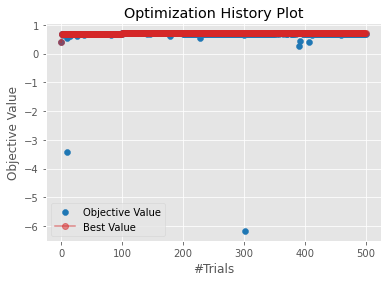

In [99]:
plot_optimization_history(study_xgb);

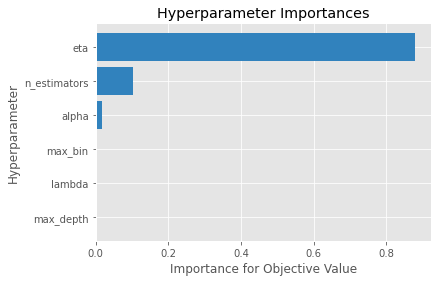

In [100]:
plot_param_importances(study_xgb);

In [101]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.706836,0.036340
1,TP,197.800000,10.850499
2,TN,175.000000,9.786612
3,FP,38.000000,7.659417
4,FN,38.400000,7.121173
5,Accuracy,0.829925,0.021386
6,Precision,0.839276,0.028663
7,Sensitivity,0.837244,0.030658
8,Specificity,0.821640,0.035132
9,F1 score,0.837824,0.021768


In [102]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.683009,0.703984,0.706733,0.688618,0.660944,0.688256,0.705296,0.684340,0.692816,0.716655,0.693065,0.015861
1,TP,385.000000,407.000000,407.000000,390.000000,395.000000,404.000000,403.000000,400.000000,406.000000,409.000000,400.600000,8.071899
2,TN,373.000000,343.000000,332.000000,337.000000,348.000000,355.000000,349.000000,339.000000,340.000000,348.000000,346.400000,11.529672
3,FP,71.000000,73.000000,91.000000,89.000000,82.000000,68.000000,78.000000,77.000000,76.000000,81.000000,78.600000,7.381659
4,FN,70.000000,76.000000,69.000000,83.000000,74.000000,72.000000,69.000000,83.000000,77.000000,61.000000,73.400000,6.752777
5,Accuracy,0.843159,0.834260,0.822024,0.808676,0.826474,0.844271,0.836485,0.822024,0.829811,0.842047,0.830923,0.011392
6,Precision,0.844298,0.847917,0.817269,0.814196,0.828092,0.855932,0.837838,0.838574,0.842324,0.834694,0.836113,0.013117
7,Sensitivity,0.846154,0.842650,0.855042,0.824524,0.842217,0.848739,0.853814,0.828157,0.840580,0.870213,0.845209,0.013186
8,Specificity,0.840100,0.824500,0.784900,0.791100,0.809300,0.839200,0.817300,0.814900,0.817300,0.811200,0.814980,0.017766
9,F1 score,0.845225,0.845275,0.835729,0.819328,0.835095,0.852321,0.845750,0.833333,0.841451,0.852083,0.840559,0.009995


In [103]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id, xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,CHEMBL4286867,0,7.25,6.965282,7.050974,6.739079,7.017837,6.849146,6.978720,0.160593
1,CHEMBL3689853,1,6.43,6.434065,6.476816,6.510091,6.577776,6.688014,6.519460,0.090381
2,CHEMBL3827056,2,7.52,8.618092,8.603618,8.515635,8.471696,8.670535,8.399929,0.398983
3,CHEMBL3689883,3,7.70,7.431558,7.452407,7.480423,7.313440,7.454924,7.472125,0.115114
4,CHEMBL2023528,4,7.27,7.408311,7.459652,7.614225,7.310424,7.139741,7.367059,0.150370
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4464975,4487,4.72,5.115430,5.127100,5.109037,5.086132,5.153950,5.051942,0.149833
4488,CHEMBL95747,4488,7.60,6.654265,6.944799,6.658501,6.720073,6.823662,6.900217,0.328866
4489,CHEMBL4072618,4489,5.19,5.192938,5.047009,5.023721,5.078069,5.008158,5.089983,0.074920
4490,CHEMBL2408692,4490,6.36,6.704311,6.439009,6.437019,6.646519,6.302081,6.481490,0.145839


In [104]:
mat_met_optimized_xgb.to_csv('mat_met_xgb_opt.csv')
xgb_5preds.to_csv('xgb_5test_CV_result.csv')

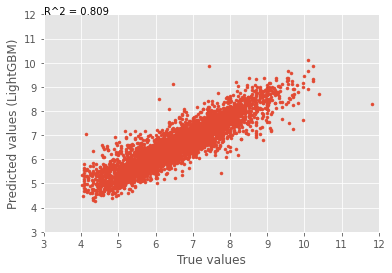

In [105]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (3, 12))
plt.show()

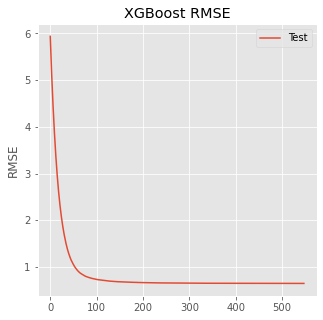

In [106]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [107]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6581 with a standard deviation of 0.0312
XGBoost optimized model r2_score 0.7100 with a standard deviation of 0.0288


In [108]:
joblib.dump(xgb_reg, "./xgb_reg.joblib")
#joblib.dump(optimized_xgb, "./optimized_xgb.joblib")
joblib.dump(optimizedCV_xgb, "./optimizedCV_xgb.joblib")


['./optimizedCV_xgb.joblib']

## KNeighbors (KNN)

In [109]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.653358     0.045847
1                    TP       192.900000    11.357328
2                    TN       169.900000     7.370361
3                    FP        43.100000     7.125073
4                    FN        43.300000     6.219146
5              Accuracy         0.807660     0.019840
6             Precision         0.817391     0.028669
7           Sensitivity         0.816297     0.028188
8           Specificity         0.798010     0.030224
9              F1 score         0.816515     0.022641
10  F1 score (weighted)         0.807609     0.019891
11     F1 score (macro)         0.806939     0.019572
12    Balanced Accuracy         0.807153     0.019665
13                  MCC         0.614594     0.039061
14                  NPV         0.797500     0.021675
15              ROC_AUC         0.807153     0.019665
CPU times: user 21.9 s, sys: 0 ns, total: 21.9 s
Wall time: 21.9 s


In [110]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [111]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [112]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:09:30,163] A new study created in memory with name: KNNregressor
[I 2023-02-17 10:09:32,960] Trial 0 finished with value: 0.6060364174308477 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 72}. Best is trial 0 with value: 0.6060364174308477.
[I 2023-02-17 10:09:36,447] Trial 1 finished with value: 0.5286910589146528 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 0 with value: 0.6060364174308477.
[I 2023-02-17 10:09:39,237] Trial 2 finished with value: 0.5650940394849202 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 0 with value: 0.6060364174308477.
[I 2023-02-17 10:09:42,089] Trial 3 finished with value: 0.5495079088415179 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 0 with value: 0.6060364174308477.
[I 2023-02-17 10:09:44,

[I 2023-02-17 10:11:16,921] Trial 35 finished with value: 0.6356223137743446 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 85}. Best is trial 28 with value: 0.6421543709238988.
[I 2023-02-17 10:11:19,862] Trial 36 finished with value: 0.5852760847866473 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 73}. Best is trial 28 with value: 0.6421543709238988.
[I 2023-02-17 10:11:22,775] Trial 37 finished with value: 0.6360963379558026 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 83}. Best is trial 28 with value: 0.6421543709238988.
[I 2023-02-17 10:11:25,673] Trial 38 finished with value: 0.6421543709238988 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 65}. Best is trial 28 with value: 0.6421543709238988.
[I 2023-02-17 10:11:28,616] Trial 39 finished with value: 0.5415387147615924 and parameters: {'n_n

	Number of trials: 50.0
	Best value (r2_score): 0.6452
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 67


In [113]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
y_pred_knn_0_cat = np.where((y_pred_knn_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.633858
1                    TP  384.000000
2                    TN  353.000000
3                    FP   91.000000
4                    FN   71.000000
5              Accuracy    0.819800
6             Precision    0.808421
7           Sensitivity    0.843956
8           Specificity    0.795000
9              F1 score    0.825806
10  F1 score (weighted)    0.819661
11     F1 score (macro)    0.819585
12    Balanced Accuracy    0.819501
13                  MCC    0.639984
14                  NPV    0.832500
15              ROC_AUC    0.819501


In [114]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:12:01,384] Trial 50 finished with value: 0.6505982556079861 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 61}. Best is trial 50 with value: 0.6505982556079861.
[I 2023-02-17 10:12:04,199] Trial 51 finished with value: 0.6505982556079861 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 50 with value: 0.6505982556079861.
[I 2023-02-17 10:12:07,013] Trial 52 finished with value: 0.6505982556079861 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 63}. Best is trial 50 with value: 0.6505982556079861.
[I 2023-02-17 10:12:09,918] Trial 53 finished with value: 0.6458022448633686 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 62}. Best is trial 50 with value: 0.6505982556079861.
[I 2023-02-17 10:12:12,763] Trial 54 finished with value: 0.6458022448633686 and parameters: {'n_nei

[I 2023-02-17 10:13:46,523] Trial 85 finished with value: 0.6506103286762348 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 34}. Best is trial 73 with value: 0.6507709416512197.
[I 2023-02-17 10:13:49,422] Trial 86 finished with value: 0.6368847775514146 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 33}. Best is trial 73 with value: 0.6507709416512197.
[I 2023-02-17 10:13:52,338] Trial 87 finished with value: 0.6257140006438953 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 34}. Best is trial 73 with value: 0.6507709416512197.
[I 2023-02-17 10:13:55,253] Trial 88 finished with value: 0.6507709416512197 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 39}. Best is trial 73 with value: 0.6507709416512197.
[I 2023-02-17 10:13:58,211] Trial 89 finished with value: 0.6507709416512197 and parameters: {'n_neig

	Number of trials: 100.0
	Best value (r2_score): 0.6508
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 30


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
y_pred_knn_1_cat = np.where((y_pred_knn_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.633858    0.655985
1                    TP  384.000000  404.000000
2                    TN  353.000000  330.000000
3                    FP   91.000000   86.000000
4                    FN   71.000000   79.000000
5              Accuracy    0.819800    0.816463
6             Precision    0.808421    0.824490
7           Sensitivity    0.843956    0.836439
8           Specificity    0.795000    0.793300
9              F1 score    0.825806    0.830421
10  F1 score (weighted)    0.819661    0.816344
11     F1 score (macro)    0.819585    0.815211
12    Balanced Accuracy    0.819501    0.814854
13                  MCC    0.639984    0.630521
14                  NPV    0.832500    0.806800
15              ROC_AUC    0.819501    0.814854


In [116]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:14:31,949] Trial 100 finished with value: 0.6551252619712643 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 100 with value: 0.6551252619712643.
[I 2023-02-17 10:14:35,611] Trial 101 finished with value: 0.6551252619712643 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 20}. Best is trial 100 with value: 0.6551252619712643.
[I 2023-02-17 10:14:39,206] Trial 102 finished with value: 0.6551252619712643 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 100 with value: 0.6551252619712643.
[I 2023-02-17 10:14:43,089] Trial 103 finished with value: 0.6551252619712643 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 20}. Best is trial 100 with value: 0.6551252619712643.
[I 2023-02-17 10:14:47,146] Trial 104 finished with value: 0.6476642373990927 and parameters

[I 2023-02-17 10:16:54,898] Trial 135 finished with value: 0.6583774426613738 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 20}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:16:57,806] Trial 136 finished with value: 0.6582877869542254 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 26}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:00,746] Trial 137 finished with value: 0.6582877869542254 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 28}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:03,711] Trial 138 finished with value: 0.6582877869542254 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 28}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:06,668] Trial 139 finished with value: 0.6505666792051127 and parameters

	Number of trials: 150.0
	Best value (r2_score): 0.6584
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 24


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
y_pred_knn_2_cat = np.where((y_pred_knn_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.633858    0.655985    0.641940
1                    TP  384.000000  404.000000  401.000000
2                    TN  353.000000  330.000000  335.000000
3                    FP   91.000000   86.000000   88.000000
4                    FN   71.000000   79.000000   75.000000
5              Accuracy    0.819800    0.816463    0.818687
6             Precision    0.808421    0.824490    0.820041
7           Sensitivity    0.843956    0.836439    0.842437
8           Specificity    0.795000    0.793300    0.792000
9              F1 score    0.825806    0.830421    0.831088
10  F1 score (weighted)    0.819661    0.816344    0.818494
11     F1 score (macro)    0.819585    0.815211    0.817705
12    Balanced Accuracy    0.819501    0.814854    0.817200
13                  MCC    0.639984    0.630521    0.635755
14                  NPV    0.832500    0.806800    0.817100
15              ROC_AUC    0.819501    0

In [118]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:17:41,363] Trial 150 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 28}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:44,290] Trial 151 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 29}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:47,248] Trial 152 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 26}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:50,155] Trial 153 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 32}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:17:53,109] Trial 154 finished with value: 0.6496926714603524 and parameters

[I 2023-02-17 10:19:34,304] Trial 185 finished with value: 0.6475551736549566 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 25}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:19:37,388] Trial 186 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 30}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:19:40,476] Trial 187 finished with value: 0.6496926714603524 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 27}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:19:43,622] Trial 188 finished with value: 0.6543250442000519 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 31}. Best is trial 133 with value: 0.6583774426613738.
[I 2023-02-17 10:19:47,397] Trial 189 finished with value: 0.6475551736549566 and parameters

	Number of trials: 200.0
	Best value (r2_score): 0.6584
	Best params:
		n_neighbors: 7
		weights: distance
		metric: manhattan
		leaf_size: 24


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
y_pred_knn_3_cat = np.where((y_pred_knn_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.633858    0.655985    0.641940    0.640618
1                    TP  384.000000  404.000000  401.000000  382.000000
2                    TN  353.000000  330.000000  335.000000  341.000000
3                    FP   91.000000   86.000000   88.000000   85.000000
4                    FN   71.000000   79.000000   75.000000   91.000000
5              Accuracy    0.819800    0.816463    0.818687    0.804227
6             Precision    0.808421    0.824490    0.820041    0.817987
7           Sensitivity    0.843956    0.836439    0.842437    0.807611
8           Specificity    0.795000    0.793300    0.792000    0.800500
9              F1 score    0.825806    0.830421    0.831088    0.812766
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819
12    Balanced Accuracy    0.819501    0.814854    0.817200    0

In [120]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:20:27,036] Trial 200 finished with value: 0.6625617631816063 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 200 with value: 0.6625617631816063.
[I 2023-02-17 10:20:31,607] Trial 201 finished with value: 0.6625617631816063 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 21}. Best is trial 200 with value: 0.6625617631816063.
[I 2023-02-17 10:20:35,261] Trial 202 finished with value: 0.6625617631816063 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 22}. Best is trial 200 with value: 0.6625617631816063.
[I 2023-02-17 10:20:38,167] Trial 203 finished with value: 0.6631138739217844 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 26}. Best is trial 203 with value: 0.6631138739217844.
[I 2023-02-17 10:20:41,054] Trial 204 finished with value: 0.6631138739217844 and parameters

[I 2023-02-17 10:22:12,764] Trial 235 finished with value: 0.663091049073954 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 34}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:22:15,707] Trial 236 finished with value: 0.663091049073954 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 40}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:22:18,645] Trial 237 finished with value: 0.663091049073954 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 41}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:22:21,688] Trial 238 finished with value: 0.663091049073954 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 40}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:22:24,598] Trial 239 finished with value: 0.663091049073954 and parameters: {'n

	Number of trials: 250.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
y_pred_knn_4_cat = np.where((y_pred_knn_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

In [122]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:22:57,812] Trial 250 finished with value: 0.637414281599172 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 36}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:23:01,338] Trial 251 finished with value: 0.6432311885334485 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 33}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:23:04,830] Trial 252 finished with value: 0.6432311885334485 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 34}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:23:08,099] Trial 253 finished with value: 0.637414281599172 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:23:11,369] Trial 254 finished with value: 0.637414281599172 and parameters: {

[I 2023-02-17 10:24:51,727] Trial 285 finished with value: 0.5238029724829627 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 41}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:24:54,956] Trial 286 finished with value: 0.637414281599172 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 32}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:24:58,166] Trial 287 finished with value: 0.6352064075300753 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 44}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:01,298] Trial 288 finished with value: 0.637414281599172 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 46}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:04,534] Trial 289 finished with value: 0.6432311885334485 and parameters: 

	Number of trials: 300.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
y_pred_knn_5_cat = np.where((y_pred_knn_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

In [124]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:25:41,842] Trial 300 finished with value: 0.6378845145895824 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 41}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:44,808] Trial 301 finished with value: 0.6388602069675724 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 48}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:47,739] Trial 302 finished with value: 0.6378845145895824 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 42}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:50,629] Trial 303 finished with value: 0.6388602069675724 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 40}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:25:53,503] Trial 304 finished with value: 0.6378845145895824 and parameters

[I 2023-02-17 10:27:26,502] Trial 335 finished with value: 0.6378845145895824 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 46}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:27:30,075] Trial 336 finished with value: 0.6388602069675724 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 44}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:27:33,578] Trial 337 finished with value: 0.6378845145895824 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 43}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:27:36,566] Trial 338 finished with value: 0.6378845145895824 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 34}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:27:39,585] Trial 339 finished with value: 0.6388602069675724 and parameters

	Number of trials: 350.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
y_pred_knn_6_cat = np.where((y_pred_knn_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

In [126]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:28:14,424] Trial 350 finished with value: 0.6459842545943817 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 33}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:28:17,372] Trial 351 finished with value: 0.6459842545943817 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:28:20,334] Trial 352 finished with value: 0.6479457660400335 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 35}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:28:22,867] Trial 353 finished with value: 0.6476144876119785 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 89}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:28:25,786] Trial 354 finished with value: 0.6459842545943817 and parameters

[I 2023-02-17 10:29:56,415] Trial 385 finished with value: 0.6479457660400335 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 40}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:29:59,338] Trial 386 finished with value: 0.6221505222524076 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 39}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:02,310] Trial 387 finished with value: 0.5806858166990501 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 32}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:05,313] Trial 388 finished with value: 0.6459842545943817 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 34}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:08,262] Trial 389 finished with value: 0.6479457660400335 and paramete

	Number of trials: 400.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [127]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
y_pred_knn_7_cat = np.where((y_pred_knn_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

In [128]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:30:41,743] Trial 400 finished with value: 0.6352810578844409 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 35}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:45,232] Trial 401 finished with value: 0.6320500998357516 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 35}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:48,717] Trial 402 finished with value: 0.6356480820038661 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 27}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:52,219] Trial 403 finished with value: 0.6352810578844409 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 37}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:30:55,737] Trial 404 finished with value: 0.6352810578844409 and parameters:

[I 2023-02-17 10:32:44,215] Trial 435 finished with value: 0.6356480820038661 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 36}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:32:47,766] Trial 436 finished with value: 0.6352810578844409 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 33}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:32:51,404] Trial 437 finished with value: 0.6356480820038661 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 38}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:32:54,969] Trial 438 finished with value: 0.6356480820038661 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 29}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:32:58,472] Trial 439 finished with value: 0.6300417466090414 and parameters

	Number of trials: 450.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [129]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
y_pred_knn_8_cat = np.where((y_pred_knn_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

In [130]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:33:37,723] Trial 450 finished with value: 0.6339484368134342 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 31}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:33:41,255] Trial 451 finished with value: 0.6049157327877698 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 39}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:33:44,825] Trial 452 finished with value: 0.6370987468001655 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 34}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:33:48,412] Trial 453 finished with value: 0.6416848426225934 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 29}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:33:52,166] Trial 454 finished with value: 0.6339484368134342 and parameter

[I 2023-02-17 10:35:43,477] Trial 485 finished with value: 0.6370987468001655 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 36}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:35:47,001] Trial 486 finished with value: 0.6339484368134342 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 30}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:35:50,469] Trial 487 finished with value: 0.6370987468001655 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 27}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:35:54,016] Trial 488 finished with value: 0.6370987468001655 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 36}. Best is trial 205 with value: 0.6683951559699226.
[I 2023-02-17 10:35:57,526] Trial 489 finished with value: 0.6339484368134342 and parameters

	Number of trials: 500.0
	Best value (r2_score): 0.6684
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 29


In [131]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
y_pred_knn_9_cat = np.where((y_pred_knn_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.633858    0.655985    0.641940    0.640618   
1                    TP  384.000000  404.000000  401.000000  382.000000   
2                    TN  353.000000  330.000000  335.000000  341.000000   
3                    FP   91.000000   86.000000   88.000000   85.000000   
4                    FN   71.000000   79.000000   75.000000   91.000000   
5              Accuracy    0.819800    0.816463    0.818687    0.804227   
6             Precision    0.808421    0.824490    0.820041    0.817987   
7           Sensitivity    0.843956    0.836439    0.842437    0.807611   
8           Specificity    0.795000    0.793300    0.792000    0.800500   
9              F1 score    0.825806    0.830421    0.831088    0.812766   
10  F1 score (weighted)    0.819661    0.816344    0.818494    0.804287   
11     F1 score (macro)    0.819585    0.815211    0.817705    0.803819   
12    Balanced Accuracy  

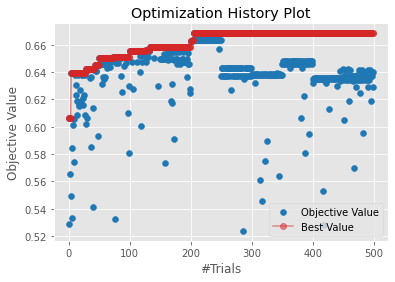

In [132]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

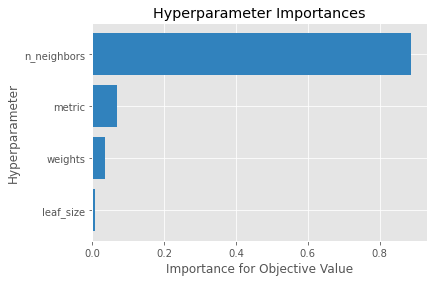

In [133]:

plot_param_importances(study_knn);

In [134]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.663500,0.043749
1,TP,195.300000,12.445883
2,TN,171.400000,7.618690
3,FP,41.600000,5.719363
4,FN,40.900000,6.822349
5,Accuracy,0.816341,0.017427
6,Precision,0.824287,0.023564
7,Sensitivity,0.826323,0.031340
8,Specificity,0.804850,0.024591
9,F1 score,0.824979,0.021651


In [135]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.633858,0.655985,0.641940,0.640618,0.581663,0.651632,0.662666,0.643630,0.647108,0.660323,0.641942,0.023067
1,TP,384.000000,404.000000,401.000000,382.000000,394.000000,396.000000,403.000000,389.000000,384.000000,395.000000,393.200000,8.148620
2,TN,353.000000,330.000000,335.000000,341.000000,348.000000,353.000000,352.000000,338.000000,336.000000,335.000000,342.100000,8.646772
3,FP,91.000000,86.000000,88.000000,85.000000,82.000000,70.000000,75.000000,78.000000,80.000000,94.000000,82.900000,7.385421
4,FN,71.000000,79.000000,75.000000,91.000000,75.000000,80.000000,69.000000,94.000000,99.000000,75.000000,80.800000,10.271860
5,Accuracy,0.819800,0.816463,0.818687,0.804227,0.825362,0.833148,0.839822,0.808676,0.800890,0.812013,0.817909,0.012343
6,Precision,0.808421,0.824490,0.820041,0.817987,0.827731,0.849785,0.843096,0.832976,0.827586,0.807771,0.825989,0.013563
7,Sensitivity,0.843956,0.836439,0.842437,0.807611,0.840085,0.831933,0.853814,0.805383,0.795031,0.840426,0.829711,0.019724
8,Specificity,0.795000,0.793300,0.792000,0.800500,0.809300,0.834500,0.824400,0.812500,0.807700,0.780900,0.805010,0.016109
9,F1 score,0.825806,0.830421,0.831088,0.812766,0.833862,0.840764,0.848421,0.818947,0.810982,0.823775,0.827683,0.011809


In [136]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id, knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4286867,0,7.25,6.612508,6.612508,6.612508,6.612508,6.352919,6.675492,0.273855
1,CHEMBL3689853,1,6.43,6.527694,6.565434,6.565434,6.624664,6.565434,6.546443,0.059317
2,CHEMBL3827056,2,7.52,8.847714,8.676487,8.804887,8.804887,8.667661,8.553606,0.467125
3,CHEMBL3689883,3,7.70,7.476192,7.475491,7.476192,7.453349,7.476192,7.509569,0.085565
4,CHEMBL2023528,4,7.27,7.565466,7.565466,7.976889,7.377892,7.395386,7.525183,0.227649
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4464975,4487,4.72,4.970271,4.968747,4.970271,4.970271,5.018218,4.936296,0.098329
4488,CHEMBL95747,4488,7.60,7.611925,7.611925,7.611925,7.611925,7.611925,7.609938,0.004444
4489,CHEMBL4072618,4489,5.19,5.225391,5.225391,5.225391,5.447661,5.365936,5.279961,0.093578
4490,CHEMBL2408692,4490,6.36,6.183897,6.056376,6.056376,6.056376,5.786719,6.083291,0.171667


In [137]:
mat_met_optimized_knn.to_csv('mat_met_knn_opt.csv')
knn_5preds.to_csv('knn_5test_CV_result.csv')

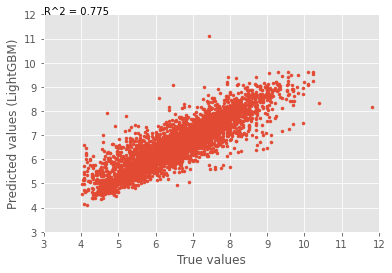

In [138]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (3, 12))
plt.show()

In [139]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6461 with a standard deviation of 0.0490
KNN optimized model r2_score 0.6563 with a standard deviation of 0.0360


In [140]:
joblib.dump(knn_reg, "./knn_reg.joblib")
#joblib.dump(optimized_knn, "./optimized_knn.joblib")
joblib.dump(optimizedCV_knn, "./optimizedCV_knn.joblib")
#loaded_rf = joblib.load("./optimized_rf.joblib")

['./optimizedCV_knn.joblib']

## Support Vector 

In [141]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.682841     0.031607
1                    TP       200.100000    11.647126
2                    TN       173.300000     7.846443
3                    FP        39.700000     6.056218
4                    FN        36.100000     5.782156
5              Accuracy         0.831257     0.022045
6             Precision         0.834193     0.026354
7           Sensitivity         0.846704     0.027051
8           Specificity         0.813770     0.026699
9              F1 score         0.840263     0.024010
10  F1 score (weighted)         0.831150     0.022040
11     F1 score (macro)         0.830455     0.021908
12    Balanced Accuracy         0.830238     0.021904
13                  MCC         0.661337     0.044008
14                  NPV         0.828020     0.023753
15              ROC_AUC         0.830238     0.021904
CPU times: user 1min 52s, sys: 20 ms, total: 1min 52s
Wall time: 1min 52s


In [142]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [143]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [144]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 10:39:33,855] A new study created in memory with name: SVM_regressor_CV
[I 2023-02-17 10:40:46,598] Trial 0 finished with value: 0.6861586526770982 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 0 with value: 0.6861586526770982.
[I 2023-02-17 10:42:01,434] Trial 1 finished with value: 0.5613614315365678 and parameters: {'C': 8.0, 'gamma': 0.0625}. Best is trial 0 with value: 0.6861586526770982.
[I 2023-02-17 10:43:13,859] Trial 2 finished with value: 0.6548407940168186 and parameters: {'C': 1.0, 'gamma': 0.03125}. Best is trial 0 with value: 0.6861586526770982.
[I 2023-02-17 10:44:27,238] Trial 3 finished with value: 0.6061062996204835 and parameters: {'C': 0.5, 'gamma': 0.03125}. Best is trial 0 with value: 0.6861586526770982.
[I 2023-02-17 10:45:45,216] Trial 4 finished with value: 0.005494939194962167 and parameters: {'C': 0.125, 'gamma': 4.0}. Best is trial 0 with value: 0.6861586526770982.
[I 2023-02-17 10:47:04,095] Trial 5 finished with value: 0.0297

[I 2023-02-17 11:35:53,241] Trial 44 finished with value: 0.548334106132505 and parameters: {'C': 32.0, 'gamma': 0.000244140625}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:37:11,638] Trial 45 finished with value: 0.10057320417515118 and parameters: {'C': 2.0, 'gamma': 3.0517578125e-05}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:38:29,600] Trial 46 finished with value: 0.050773362055710314 and parameters: {'C': 0.5, 'gamma': 0.25}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:39:47,876] Trial 47 finished with value: 0.15530000491415946 and parameters: {'C': 0.0625, 'gamma': 0.001953125}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:41:05,767] Trial 48 finished with value: 0.24944828210324585 and parameters: {'C': 2.0, 'gamma': 0.0001220703125}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:42:23,645] Trial 49 finished with value: 0.03212709981391596 and parameters: {'C': 128.0, 

	Number of trials: 50.0
	Best value (r2_score): 0.6869
	Best params:
		C: 2.0
		gamma: 0.015625


In [145]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_0_cat = np.where((y_pred_svm_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.679806
1                    TP  386.000000
2                    TN  363.000000
3                    FP   81.000000
4                    FN   69.000000
5              Accuracy    0.833148
6             Precision    0.826552
7           Sensitivity    0.848352
8           Specificity    0.817600
9              F1 score    0.837310
10  F1 score (weighted)    0.833091
11     F1 score (macro)    0.833039
12    Balanced Accuracy    0.832960
13                  MCC    0.666375
14                  NPV    0.840300
15              ROC_AUC    0.832960


In [146]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 11:43:51,001] Trial 50 finished with value: 0.02932827686226521 and parameters: {'C': 0.03125, 'gamma': 0.00048828125}. Best is trial 27 with value: 0.6869174934677498.
[I 2023-02-17 11:45:02,763] Trial 51 finished with value: 0.6879162878794457 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.6879162878794457.
[I 2023-02-17 11:46:14,216] Trial 52 finished with value: 0.6879162878794457 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 51 with value: 0.6879162878794457.
[I 2023-02-17 11:47:32,361] Trial 53 finished with value: 0.07862763779587414 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 51 with value: 0.6879162878794457.
[I 2023-02-17 11:48:49,942] Trial 54 finished with value: -8.58716432976525e-06 and parameters: {'C': 0.015625, 'gamma': 0.5}. Best is trial 51 with value: 0.6879162878794457.
[I 2023-02-17 11:50:04,990] Trial 55 finished with value: 0.4795327109168598 and parameters: {'C': 2.0, 'gamma': 0.

[I 2023-02-17 12:38:11,971] Trial 94 finished with value: 0.0360282582536241 and parameters: {'C': 0.5, 'gamma': 1.0}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:39:28,211] Trial 95 finished with value: 0.09730018233772866 and parameters: {'C': 0.0625, 'gamma': 0.0009765625}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:40:47,973] Trial 96 finished with value: 0.03976717717855559 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:42:04,552] Trial 97 finished with value: 0.22062189342318583 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:43:16,729] Trial 98 finished with value: 0.6925464892049689 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:44:33,462] Trial 99 finished with value: 0.083926300636999 and parameters: {'C': 0.015625, 'gamma': 0.00390625}.

	Number of trials: 100.0
	Best value (r2_score): 0.6949
	Best params:
		C: 4.0
		gamma: 0.015625


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_1_cat = np.where((y_pred_svm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.679806    0.705457
1                    TP  386.000000  403.000000
2                    TN  363.000000  352.000000
3                    FP   81.000000   64.000000
4                    FN   69.000000   80.000000
5              Accuracy    0.833148    0.839822
6             Precision    0.826552    0.862955
7           Sensitivity    0.848352    0.834369
8           Specificity    0.817600    0.846200
9              F1 score    0.837310    0.848421
10  F1 score (weighted)    0.833091    0.839984
11     F1 score (macro)    0.833039    0.839305
12    Balanced Accuracy    0.832960    0.840261
13                  MCC    0.666375    0.679145
14                  NPV    0.840300    0.814800
15              ROC_AUC    0.832960    0.840261


In [148]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 12:46:00,220] Trial 100 finished with value: 0.08004737746695395 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 65 with value: 0.6949151893739066.
[I 2023-02-17 12:47:11,542] Trial 101 finished with value: 0.7029789511449824 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 12:48:22,748] Trial 102 finished with value: 0.7029789511449824 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 12:49:33,953] Trial 103 finished with value: 0.7029789511449824 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 12:50:45,207] Trial 104 finished with value: 0.7029789511449824 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 12:51:59,335] Trial 105 finished with value: 0.5724893215021546 and parameters: {'C': 4.0, 'gamma': 0.062

[I 2023-02-17 13:40:25,299] Trial 144 finished with value: 0.6985504711051671 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:41:46,174] Trial 145 finished with value: 0.08004737746695395 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:43:04,757] Trial 146 finished with value: 0.4262086586624034 and parameters: {'C': 0.125, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:44:19,036] Trial 147 finished with value: 0.699249866399613 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:45:36,795] Trial 148 finished with value: 0.571947394947647 and parameters: {'C': 16.0, 'gamma': 0.0625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:46:52,226] Trial 149 finished with value: 0.699249866399613 and parameters: {'C': 16.0, 'gamma': 0.0

	Number of trials: 150.0
	Best value (r2_score): 0.7030
	Best params:
		C: 4.0
		gamma: 0.015625


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_2_cat = np.where((y_pred_svm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.679806    0.705457    0.705767
1                    TP  386.000000  403.000000  408.000000
2                    TN  363.000000  352.000000  338.000000
3                    FP   81.000000   64.000000   85.000000
4                    FN   69.000000   80.000000   68.000000
5              Accuracy    0.833148    0.839822    0.829811
6             Precision    0.826552    0.862955    0.827586
7           Sensitivity    0.848352    0.834369    0.857143
8           Specificity    0.817600    0.846200    0.799100
9              F1 score    0.837310    0.848421    0.842105
10  F1 score (weighted)    0.833091    0.839984    0.829559
11     F1 score (macro)    0.833039    0.839305    0.828773
12    Balanced Accuracy    0.832960    0.840261    0.828099
13                  MCC    0.666375    0.679145    0.658145
14                  NPV    0.840300    0.814800    0.832500
15              ROC_AUC    0.832960    0

In [150]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 13:48:20,317] Trial 150 finished with value: 0.6658005092943367 and parameters: {'C': 16.0, 'gamma': 0.00390625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:49:34,543] Trial 151 finished with value: 0.6963652779338455 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:50:48,602] Trial 152 finished with value: 0.6963652779338455 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:52:03,243] Trial 153 finished with value: 0.6963652779338455 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:53:18,244] Trial 154 finished with value: 0.7013525414401401 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 13:54:32,205] Trial 155 finished with value: 0.7013525414401401 and parameters: {'C': 4.0, 'gamma': 0.015

[I 2023-02-17 14:43:15,538] Trial 194 finished with value: 0.5321199454996723 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:44:36,295] Trial 195 finished with value: 0.03810957774990008 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:45:47,482] Trial 196 finished with value: 0.7013525414401401 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:46:57,729] Trial 197 finished with value: 0.7013525414401401 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:48:08,953] Trial 198 finished with value: 0.7013525414401401 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:49:27,125] Trial 199 finished with value: 0.003546801471684502 and parameters: {'C': 0.0625, 'gamma': 1.0}. Bes

	Number of trials: 200.0
	Best value (r2_score): 0.7030
	Best params:
		C: 4.0
		gamma: 0.015625


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_3_cat = np.where((y_pred_svm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.679806    0.705457    0.705767    0.689205
1                    TP  386.000000  403.000000  408.000000  396.000000
2                    TN  363.000000  352.000000  338.000000  346.000000
3                    FP   81.000000   64.000000   85.000000   80.000000
4                    FN   69.000000   80.000000   68.000000   77.000000
5              Accuracy    0.833148    0.839822    0.829811    0.825362
6             Precision    0.826552    0.862955    0.827586    0.831933
7           Sensitivity    0.848352    0.834369    0.857143    0.837209
8           Specificity    0.817600    0.846200    0.799100    0.812200
9              F1 score    0.837310    0.848421    0.842105    0.834563
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820
12    Balanced Accuracy    0.832960    0.840261    0.828099    0

In [152]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 14:50:50,207] Trial 200 finished with value: 0.6224760934146432 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:52:03,810] Trial 201 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:53:17,513] Trial 202 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:54:31,084] Trial 203 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:55:44,861] Trial 204 finished with value: 0.6451326005628639 and parameters: {'C': 4.0, 'gamma': 0.00390625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 14:56:56,097] Trial 205 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}

[I 2023-02-17 15:43:31,552] Trial 244 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:44:42,234] Trial 245 finished with value: 0.5915340267710907 and parameters: {'C': 4.0, 'gamma': 0.001953125}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:45:54,765] Trial 246 finished with value: 0.3262716573735622 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:47:03,703] Trial 247 finished with value: 0.6999351494536421 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:48:18,314] Trial 248 finished with value: 0.3345033069557709 and parameters: {'C': 0.5, 'gamma': 0.0009765625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:49:30,632] Trial 249 finished with value: 0.4179094714458106 and parameters: {'C': 4.0, 'gamma': 0

	Number of trials: 250.0
	Best value (r2_score): 0.7030
	Best params:
		C: 4.0
		gamma: 0.015625


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_4_cat = np.where((y_pred_svm_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [154]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 15:50:48,619] Trial 250 finished with value: 0.6944542251677415 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:52:04,369] Trial 251 finished with value: 0.05290149858627372 and parameters: {'C': 128.0, 'gamma': 0.5}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:53:20,991] Trial 252 finished with value: 0.04074616516171871 and parameters: {'C': 4.0, 'gamma': 1.0}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:54:31,033] Trial 253 finished with value: 0.6944542251677415 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:55:41,857] Trial 254 finished with value: 0.6845129636011018 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 15:57:00,691] Trial 255 finished with value: -0.0011037055710534816 and parameters: {'C': 0.015625, 'gamma': 8.0}. B

[I 2023-02-17 16:43:37,820] Trial 294 finished with value: 0.02927460156152497 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:44:46,732] Trial 295 finished with value: 0.6944542251677415 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:45:55,723] Trial 296 finished with value: 0.6944542251677415 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:47:04,460] Trial 297 finished with value: 0.6944542251677415 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:48:19,063] Trial 298 finished with value: 0.07800436330366303 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:49:30,167] Trial 299 finished with value: 0.5241956781365242 and parameters: {'C': 4.0, 'gamma': 0.000976

	Number of trials: 300.0
	Best value (r2_score): 0.7030
	Best params:
		C: 4.0
		gamma: 0.015625


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_5_cat = np.where((y_pred_svm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [156]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 16:50:54,533] Trial 300 finished with value: 0.011101421796047128 and parameters: {'C': 0.125, 'gamma': 1.0}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:52:04,402] Trial 301 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:53:15,041] Trial 302 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:54:28,434] Trial 303 finished with value: 0.5612531937021741 and parameters: {'C': 4.0, 'gamma': 0.0625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:55:39,556] Trial 304 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 16:56:51,737] Trial 305 finished with value: 0.55701782485736 and parameters: {'C': 1.0, 'gamma': 0.00390625}. Bes

[I 2023-02-17 17:43:22,151] Trial 344 finished with value: 0.628315967176029 and parameters: {'C': 4.0, 'gamma': 0.00390625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 17:44:30,964] Trial 345 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 17:45:39,842] Trial 346 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 17:46:51,687] Trial 347 finished with value: 0.3451610009460665 and parameters: {'C': 0.25, 'gamma': 0.0625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 17:48:00,636] Trial 348 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7029789511449824.
[I 2023-02-17 17:49:09,520] Trial 349 finished with value: 0.6992537545690346 and parameters: {'C': 4.0, 'gamma': 0.015625}. 

	Number of trials: 350.0
	Best value (r2_score): 0.7030
	Best params:
		C: 4.0
		gamma: 0.015625


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_6_cat = np.where((y_pred_svm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [158]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 17:50:28,177] Trial 350 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 17:51:37,582] Trial 351 finished with value: 0.697400772262081 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 17:52:46,686] Trial 352 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 17:53:55,723] Trial 353 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 17:55:04,204] Trial 354 finished with value: 0.6841101862459678 and parameters: {'C': 4.0, 'gamma': 0.03125}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 17:56:16,771] Trial 355 finished with value: 0.3207164019991003 and parameters: {'C': 0.0625, 'gamma': 0.015625}.

[I 2023-02-17 18:42:03,051] Trial 394 finished with value: 0.5341605667786775 and parameters: {'C': 0.25, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:43:16,550] Trial 395 finished with value: 0.046611089985133594 and parameters: {'C': 4.0, 'gamma': 1.0}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:44:27,219] Trial 396 finished with value: 0.697400772262081 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:45:37,730] Trial 397 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:46:45,975] Trial 398 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:47:54,303] Trial 399 finished with value: 0.7041860882767477 and parameters: {'C': 4.0, 'gamma': 0.015625}. Bes

	Number of trials: 400.0
	Best value (r2_score): 0.7042
	Best params:
		C: 4.0
		gamma: 0.015625


In [159]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_7_cat = np.where((y_pred_svm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [160]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 18:49:12,063] Trial 400 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:50:20,307] Trial 401 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:51:30,397] Trial 402 finished with value: 0.5590190038088061 and parameters: {'C': 4.0, 'gamma': 0.0625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:52:41,606] Trial 403 finished with value: 0.6529473303405207 and parameters: {'C': 16.0, 'gamma': 0.00390625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:53:49,750] Trial 404 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 18:54:58,002] Trial 405 finished with value: 0.6163690282150046 and parameters: {'C': 0.5, 'gamma': 0.015625}.

[I 2023-02-17 19:40:26,834] Trial 444 finished with value: 0.4890511817719322 and parameters: {'C': 0.5, 'gamma': 0.00390625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:41:33,640] Trial 445 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:42:40,495] Trial 446 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:43:46,687] Trial 447 finished with value: 0.687149317215001 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:44:55,399] Trial 448 finished with value: 0.5590190038088061 and parameters: {'C': 4.0, 'gamma': 0.0625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:46:02,220] Trial 449 finished with value: 0.6896695894266649 and parameters: {'C': 4.0, 'gamma': 0.015625}. B

	Number of trials: 450.0
	Best value (r2_score): 0.7042
	Best params:
		C: 4.0
		gamma: 0.015625


In [161]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_8_cat = np.where((y_pred_svm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [162]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-02-17 19:47:18,772] Trial 450 finished with value: 0.684733214416044 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:48:28,202] Trial 451 finished with value: 0.5377987922646418 and parameters: {'C': 128.0, 'gamma': 6.103515625e-05}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:49:39,285] Trial 452 finished with value: 0.1028342039312079 and parameters: {'C': 0.015625, 'gamma': 0.03125}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:50:46,347] Trial 453 finished with value: 0.6735433795157324 and parameters: {'C': 4.0, 'gamma': 0.0078125}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:51:57,321] Trial 454 finished with value: 0.21766074393080181 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 19:53:04,671] Trial 455 finished with value: 0.6839619907728756 and parameters: {'C': 64.0, 

[I 2023-02-17 20:37:44,529] Trial 494 finished with value: 0.1336570943869106 and parameters: {'C': 0.015625, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 20:38:51,179] Trial 495 finished with value: 0.6879215576825776 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 20:40:02,358] Trial 496 finished with value: 0.25114000443746143 and parameters: {'C': 4.0, 'gamma': 6.103515625e-05}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 20:41:13,723] Trial 497 finished with value: 0.07539355953505508 and parameters: {'C': 0.0078125, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 20:42:24,706] Trial 498 finished with value: 0.21766074393080181 and parameters: {'C': 0.03125, 'gamma': 0.015625}. Best is trial 350 with value: 0.7041860882767477.
[I 2023-02-17 20:43:36,968] Trial 499 finished with value: 0.02888311783155576 and parameters: {'C':

	Number of trials: 500.0
	Best value (r2_score): 0.7042
	Best params:
		C: 4.0
		gamma: 0.015625


In [163]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_9_cat = np.where((y_pred_svm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.679806    0.705457    0.705767    0.689205   
1                    TP  386.000000  403.000000  408.000000  396.000000   
2                    TN  363.000000  352.000000  338.000000  346.000000   
3                    FP   81.000000   64.000000   85.000000   80.000000   
4                    FN   69.000000   80.000000   68.000000   77.000000   
5              Accuracy    0.833148    0.839822    0.829811    0.825362   
6             Precision    0.826552    0.862955    0.827586    0.831933   
7           Sensitivity    0.848352    0.834369    0.857143    0.837209   
8           Specificity    0.817600    0.846200    0.799100    0.812200   
9              F1 score    0.837310    0.848421    0.842105    0.834563   
10  F1 score (weighted)    0.833091    0.839984    0.829559    0.825329   
11     F1 score (macro)    0.833039    0.839305    0.828773    0.824820   
12    Balanced Accuracy  

In [164]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7042
	Best params:
		C: 4.0
		gamma: 0.015625


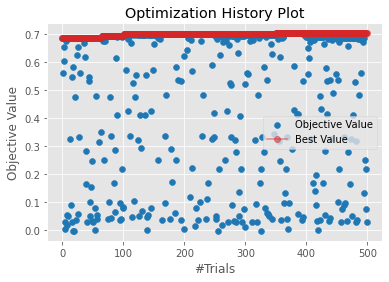

In [165]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [166]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [167]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.712493,0.030623
1,TP,200.700000,12.147702
2,TN,176.200000,8.256984
3,FP,36.800000,7.083627
4,FN,35.500000,7.261007
5,Accuracy,0.839049,0.026312
6,Precision,0.844872,0.030123
7,Sensitivity,0.849293,0.033075
8,Specificity,0.827480,0.031275
9,F1 score,0.846846,0.028041


In [168]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.679806,0.705457,0.705767,0.689205,0.661992,0.692112,0.701017,0.687767,0.694730,0.728578,0.694643,0.017646
1,TP,386.000000,403.000000,408.000000,396.000000,393.000000,409.000000,399.000000,398.000000,407.000000,410.000000,400.900000,7.894442
2,TN,363.000000,352.000000,338.000000,346.000000,357.000000,356.000000,360.000000,347.000000,339.000000,346.000000,350.400000,8.579044
3,FP,81.000000,64.000000,85.000000,80.000000,73.000000,67.000000,67.000000,69.000000,77.000000,83.000000,74.600000,7.574812
4,FN,69.000000,80.000000,68.000000,77.000000,76.000000,67.000000,73.000000,85.000000,76.000000,60.000000,73.100000,7.248755
5,Accuracy,0.833148,0.839822,0.829811,0.825362,0.834260,0.850945,0.844271,0.828699,0.829811,0.840934,0.835706,0.008056
6,Precision,0.826552,0.862955,0.827586,0.831933,0.843348,0.859244,0.856223,0.852248,0.840909,0.831643,0.843264,0.013686
7,Sensitivity,0.848352,0.834369,0.857143,0.837209,0.837953,0.859244,0.845339,0.824017,0.842650,0.872340,0.845862,0.014028
8,Specificity,0.817600,0.846200,0.799100,0.812200,0.830200,0.841600,0.843100,0.834100,0.814900,0.806500,0.824550,0.016647
9,F1 score,0.837310,0.848421,0.842105,0.834563,0.840642,0.859244,0.850746,0.837895,0.841779,0.851506,0.844421,0.007767


In [169]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id, svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL4286867,0,7.25,6.906270,6.880988,6.622951,6.897095,6.782075,6.889896,0.188396
1,CHEMBL3689853,1,6.43,6.374422,6.422655,6.340521,6.369552,6.381926,6.386513,0.031004
2,CHEMBL3827056,2,7.52,8.671562,8.636064,8.595810,8.559175,8.710785,8.448899,0.418288
3,CHEMBL3689883,3,7.70,7.402379,7.380729,7.355947,7.366139,7.367487,7.428780,0.122169
4,CHEMBL2023528,4,7.27,7.691218,7.699364,7.823058,7.101727,7.099170,7.447423,0.298964
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL4464975,4487,4.72,5.215120,5.298787,5.276510,5.216893,5.212179,5.156582,0.198059
4488,CHEMBL95747,4488,7.60,6.879247,6.961059,6.791553,6.814314,6.967780,7.002325,0.275388
4489,CHEMBL4072618,4489,5.19,5.382753,5.312837,5.215983,5.359619,5.383309,5.307417,0.077821
4490,CHEMBL2408692,4490,6.36,6.325874,6.423393,6.410205,6.408914,6.090587,6.336496,0.115011


In [170]:
mat_met_optimized_svm.to_csv('mat_met_svm_opt.csv')
svm_5preds.to_csv('svm_5test_CV_result.csv')

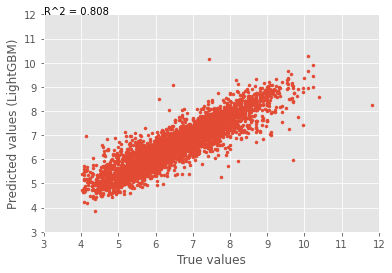

In [171]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (3, 12))
plt.show()

In [172]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6853 with a standard deviation of 0.0411
SVM optimized model r2_score 0.7155 with a standard deviation of 0.0416


In [173]:
joblib.dump(svm_reg, "./svm_reg.joblib")
#joblib.dump(optimized_svm, "./optimized_svm.joblib")
joblib.dump(optimizedCV_svm, "./optimizedCV_svm.joblib")

['./optimizedCV_svm.joblib']